# Домашняя работа

В этой работе вам предстоит с помощью encoder-decoder архитектуры, пробуя различные ее реализации, решить задачу машинного перевода.

#### Наша задача - сделать свой собственный переводчик!

Пока что только русско-английский:) Будем учиться на текстах описания отелей, так что при успешном выполнении этого задания у вас не возникнет проблем с выбором места для остановки в путешествии, так как все отзывы вам будут высококлассно переведены!

Что необходимо обсудить до начала работы?
 
*как токенезовать и закодировать текст?*

С токенезацией хорошо справится WordPunctTokenizer из библиотеки nltk, а вот с кодированием не все так просто, как может показаться... 

В наших текстах очень много редких и очень мало встречаемых слов (в каждом отеле есть своя фишка: какой-то предмет декорации или услуга, которая описывается своим словом, которое только там и встречается). Если мы будем кодировать все слова, то размер нашего словаря будет очень-очень большим.

Но на одном из семинаров мы кодировали побуквенно, кажется, что тут это может помочь! Да, действительно так, но придется очень очень долго обучать модель, а путешествовать и выбрать хороший отель уже хочется, поэтому мы придем к чему-то среднему между этими подходами -  [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt) известный как __BPE__

Этот алгоритм стартует с посимвольного уровня и итеративно мерджит самые встречаемые пары. И так N итераций. На выходе мы получаем самые частые последовательности символов из которых формируются слова!

BPE - очень популярный и частоиспользуемый алгоритм в задачах NLP, поэтому есть много открытых реализаций этого алгоритма

Мы уверены, что вы научились гуглить и искать полезные материалы в интернете, когда делали домашнее задание по YOLO, поэтому в этот раз просто покажем один из способов, как это можно сделать и затем в своих проектах вы можете брать этот подход и, возможно, как-то улучшать его!

Тем кому очень интересно, как же все работает - заходите в файл vocab.py, очень советуем!

In [3]:
!pip install nltk
!pip install subword_nmt

In [4]:
from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE


tokenizer = WordPunctTokenizer()
def tokenize(x):
    return ' '.join(tokenizer.tokenize(x.lower()))


In [2]:
# разбиваем и токенизируем тексты, записываем обработанные токены в файл
with open('/kaggle/input/dataset/train.en', 'w',encoding = 'utf8') as f_src,  open('/kaggle/input/dataset/train.ru', 'w',encoding = 'utf8') as f_dst:
    for line in open('/kaggle/input/aeeeeee/data.txt',encoding = 'utf8'):
        src_line, dst_line = line.strip().split('\t')
        f_src.write(tokenize(src_line) + '\n')
        f_dst.write(tokenize(dst_line) + '\n')

# строим и применяем bpe кодирование
bpe = {}
for lang in ['en', 'ru']:
    learn_bpe(open('/kaggle/input/dataset/train.' + lang,encoding = 'utf8'), open('/kaggle/input/dataset/bpe_rules.' + lang, 'w',encoding = 'utf8'), num_symbols=8000)
    bpe[lang] = BPE(open('/kaggle/input/dataset/bpe_rules.' + lang,encoding = 'utf8'))
    
    with open('/kaggle/input/dataset/train.bpe.' + lang, 'w',encoding = 'utf8') as f_out:
        for line in open('/kaggle/input/dataset/train.' + lang,encoding = 'utf8'):
            f_out.write(bpe[lang].process_line(line.strip()) + '\n')

OSError: [Errno 30] Read-only file system: '/kaggle/input/dataset/train.en'

### Построение словарей, разбиение данных

Сейчас, когда мы обучили BPE алгоритм на наших данных, построим словарь соответствия токена и его индекса, чтобы нам было затем удобно смотреть переводы и переводить новые предложения

Также сделаем разбиение на train/test

In [5]:
import numpy as np

In [6]:
data_inp = np.array(open('/kaggle/input/d/krotdl/dataset/train.bpe.ru',encoding = 'utf8').read().split('\n'))
data_out = np.array(open('/kaggle/input/d/krotdl/dataset/train.bpe.en',encoding = 'utf8').read().split('\n'))

from sklearn.model_selection import train_test_split
train_inp, dev_inp, train_out, dev_out = train_test_split(data_inp, data_out, test_size=3000,
                                                          random_state=42)
for i in range(100,103):
    print('inp:', train_inp[i+2])
    print('out:', train_out[i+3], end='\n\n')

inp: дом с проживанием в семье lake front расположен в городе канди , в 300 метрах от больницы лей@@ к@@ сайд ад@@ венти@@ ст . во всех зонах работает бесплатный wi - fi .
out: g@@ jer@@ r@@ il@@ d nor@@ d@@ strand beach , trout fishing opportunities and fo@@ s@@ si@@ l hunting on the cliffs are all 4 km from the hostel .

inp: в 4 км от хостела расположены пляж г@@ ьер@@ ри@@ лд нор@@ д@@ стра@@ н@@ д , место ловли л@@ ос@@ о@@ ся , а также ска@@ лы , где можно заняться по@@ и@@ ском и@@ ско@@ па@@ ем@@ ых .
out: at wind@@ haven hotel you will find a 24 - hour front desk , a garden and a terrace .

inp: в отеле win@@ d@@ ha@@ ven имеется круглосуточная стойка регистрации , сад и терраса .
out: just a 15 - minute walk from kar@@ f@@ as beach , vila cl@@ io is located in kam@@ bos , on the island of ch@@ ios . it is situated in the area of f@@ rag@@ kov@@ o@@ uni medieval village and offers self - catering accommodation and a garden with a l@@ ily pond .



In [7]:
import sys
import numpy as np
import torch
import torch.nn.functional as F

class Vocab:
    def __init__(self, tokens, bos="_BOS_", eos="_EOS_", unk='_UNK_'):
        """
        A special class that converts lines of tokens into matrices and backwards
        """
        assert all(tok in tokens for tok in (bos, eos, unk))
        self.tokens = tokens
        self.token_to_ix = {t:i for i, t in enumerate(tokens)}
        self.bos, self.eos, self.unk = bos, eos, unk
        self.bos_ix = self.token_to_ix[bos]
        self.eos_ix = self.token_to_ix[eos]
        self.unk_ix = self.token_to_ix[unk]

    def __len__(self):
        return len(self.tokens)

    @staticmethod
    def from_lines(lines, bos="_BOS_", eos="_EOS_", unk='_UNK_'):
        flat_lines = '\n'.join(list(lines)).split()
        tokens = sorted(set(flat_lines))
        tokens = [t for t in tokens if t not in (bos, eos, unk) and len(t)]
        tokens = [bos, eos, unk] + tokens
        return Vocab(tokens, bos, eos, unk)

    def tokenize(self, string):
        """converts string to a list of tokens"""
        tokens = [tok if tok in self.token_to_ix else self.unk
                  for tok in string.split()]
        return [self.bos] + tokens + [self.eos]

    def to_matrix(self, lines, dtype=torch.int64, max_len=None):
        """
        convert variable length token sequences into  fixed size matrix
        example usage:
        >>>print(to_matrix(words[:3],source_to_ix))
        [[15 22 21 28 27 13 -1 -1 -1 -1 -1]
         [30 21 15 15 21 14 28 27 13 -1 -1]
         [25 37 31 34 21 20 37 21 28 19 13]]
        """
        lines = list(map(self.tokenize, lines))
        max_len = max_len or max(map(len, lines))

        matrix = torch.full((len(lines), max_len), self.eos_ix, dtype=dtype)
        for i, seq in enumerate(lines):
            row_ix = list(map(self.token_to_ix.get, seq))[:max_len]
            matrix[i, :len(row_ix)] = torch.as_tensor(row_ix)

        return matrix

    def to_lines(self, matrix, crop=True):
        """
        Convert matrix of token ids into strings
        :param matrix: matrix of tokens of int32, shape=[batch,time]
        :param crop: if True, crops BOS and EOS from line
        :return:
        """
        lines = []
        for line_ix in map(list,matrix):
            if crop:
                if line_ix[0] == self.bos_ix:
                    line_ix = line_ix[1:]
                if self.eos_ix in line_ix:
                    line_ix = line_ix[:line_ix.index(self.eos_ix)]
            line = ' '.join(self.tokens[i] for i in line_ix)
            lines.append(line)
        return lines
    
    def compute_mask(self, input_ix):
        """ compute a boolean mask that equals "1" until first EOS (including that EOS) """
        return F.pad(torch.cumsum(input_ix == self.eos_ix, dim=-1)[..., :-1] < 1, pad=(1, 0, 0, 0), value=True)

In [8]:
inp_voc = Vocab.from_lines(train_inp)
out_voc = Vocab.from_lines(train_out)

In [9]:
# тут можно посмотреть, как работает мапинг из индекса в токен и наоборот
batch_lines = sorted(train_inp, key=len)[5:10]
batch_ids = inp_voc.to_matrix(batch_lines)
batch_lines_restored = inp_voc.to_lines(batch_ids)

print("lines")
print(batch_lines)
print("\nwords to ids (0 = bos, 1 = eos):")
print(batch_ids)
print("\nback to words")
print(batch_lines_restored)

lines
['гостевой дом r .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .', 'подключен wi - fi .']

words to ids (0 = bos, 1 = eos):
tensor([[   0, 2688, 2943, 1108,   29,    1,    1,    1],
        [   0, 2922, 1834, 8035,   59, 3800,   29,    1],
        [   0, 6030, 2083,   29,    1,    1,    1,    1],
        [   0, 4927, 1870,   29,    1,    1,    1,    1],
        [   0, 5549, 1453,   27,  592,   29,    1,    1]])

back to words
['гостевой дом r .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .', 'подключен wi - fi .']


## За вас сделали домашнюю работу? Нет, вам самое интересное!

Если вы пролистываете ноутбук и вам уже очень хочется начать писать самим - то мы вас понимаем, задание очень интересное и полезное! 
И спешим вас обрадовать, так как вы дождались и тут как раз можно проявить всю фантазию и мастерство написание нейронных сетей!


###  Задание 1 (1 балла)
В коде ниже мы представили шаблон простой encoder-decoder модели, без всяких наворотов с Attention или чем-нибудь еще. Вы можете редактировать его под себя: добавлять новые методы, новые переменные, писать на pytorch ligtning и другое.

Главное - сохраните идею шаблона и сделайте его очень удобным, так как с ним еще предстоит работать!

Заполните пропуски с `<YOUR CODE HERE>`

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [11]:
class BaseModel(nn.Module):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128):
        """
        Базовая модель encoder-decoder архитектуры
        """
        super().__init__() 

        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size
        
        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)
        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True)

        self.dec_start = nn.Linear(hid_size, hid_size)
        self.dec0 = nn.GRUCell(emb_size, hid_size)
        self.logits = nn.Linear(hid_size, len(out_voc))
        
    def forward(self, inp, out):
        """ Сначала примените  encode а затем decode"""
        initial_state = self.encode(inp)
        return self.decode(initial_state,out)


    def encode(self, inp, **flags):
        """
        Считаем скрытое состояние, которое будет начальным для decode
        :param inp: матрица входных токенов
        :returns: скрытое представление с которого будет начинаться decode
        """
        inp_emb = self.emb_inp(inp)
        batch_size = inp.shape[0]
        
        enc_seq, [last_state_but_not_really] = self.enc0(inp_emb)
        # enc_seq: [batch, time, hid_size], last_state: [batch, hid_size]
        
        # последний токен, не последние на самом деле, так как мы делали pading, чтобы тексты были
        # одинакового размер, поэтому подсчитать длину исходного предложения не так уж тривиально
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        # ^-- shape: [batch_size, hid_size]
        
        dec_start = self.dec_start(last_state)
        return [dec_start]

    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Принимает предыдущее состояние декодера и токены, возвращает новое состояние и 
        логиты для следующих токенов
        """
        tokens = self.emb_out(prev_tokens)
        prev_state = prev_state[0]
        new_dec_state = self.dec0(tokens, prev_state)
        output_logits = self.logits(new_dec_state)
        return [new_dec_state], output_logits

    def decode(self, initial_state, out_tokens, **flags):
        batch_size = out_tokens.shape[0]
        state = initial_state
        
        # первый символ всегда BOS
        onehot_bos = F.one_hot(torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64),
                               num_classes=len(self.out_voc)).to(device=out_tokens.device)
        first_logits = torch.log(onehot_bos.to(torch.float32) + 1e-9)
        
        logits_sequence = [first_logits]
        # в цикле делаем decode_step, получаем logits_sequence
        for i in range(out_tokens.shape[1] - 1):
            state, new_logits = self.decode_step(state,out_tokens[:,i])
            logits_sequence.append(new_logits)
        return torch.stack(logits_sequence, dim=1)

    def decode_inference(self, initial_state, max_len=100, **flags):
        """ Генерим токены для перевода """
        batch_size, device = len(initial_state[0]), initial_state[0].device
        state = initial_state
        outputs = [torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64, device=device)]
        all_states = [initial_state]

        for i in range(max_len):
            state, logits = self.decode_step(state, outputs[-1])
            outputs.append(logits.argmax(dim=-1))
            all_states.append(state)
        
        return torch.stack(outputs, dim=1), all_states

    def translate_lines(self, inp_lines, **kwargs):
        """Функция для перевода"""
        inp = self.inp_voc.to_matrix(inp_lines).to(device)
        initial_state = self.encode(inp)
        out_ids, states = self.decode_inference(initial_state, **kwargs)
        return self.out_voc.to_lines(out_ids.cpu().numpy()), states


In [12]:
# debugging area
model = BaseModel(inp_voc, out_voc).to(device)

dummy_inp_tokens = inp_voc.to_matrix(sorted(train_inp, key=len)[5:10]).to(device)
dummy_out_tokens = out_voc.to_matrix(sorted(train_out, key=len)[5:10]).to(device)

h0 = model.encode(dummy_inp_tokens)
h1, logits1 = model.decode_step(h0, torch.arange(len(dummy_inp_tokens), device=device))

assert isinstance(h1, list) and len(h1) == len(h0)
assert h1[0].shape == h0[0].shape and not torch.allclose(h1[0], h0[0])
assert logits1.shape == (len(dummy_inp_tokens), len(out_voc))

logits_seq = model.decode(h0, dummy_out_tokens)
assert logits_seq.shape == (dummy_out_tokens.shape[0], dummy_out_tokens.shape[1], len(out_voc))

# full forward
logits_seq2 = model(dummy_inp_tokens, dummy_out_tokens)
# print(logits_seq2)
print(logits_seq2.shape)
assert logits_seq2.shape == logits_seq.shape

torch.Size([5, 7, 7801])


In [13]:
dummy_translations, dummy_states = model.translate_lines(train_inp[:3], max_len=25)
print("Translations without training:")
print('\n'.join([line for line in dummy_translations]))

Translations without training:
late addition ou den dral uses immediate the@@ 14 screen afternoon internet ino bras@@ toyo@@ lin hoch@@ vel@@ ex@@ ite@@ ou door@@ volcano fon@@ pul@@
late venue addition kitchenettes tus@@ nos lockers athens gos kissimmee chan festivals fing ghur@@ hall media ʼ 20@@ professional swick fo@@ prac@@ traditionally airs airs
late addition ou den dral uses immediate the@@ 14 screen afternoon internet ino bras@@ toyo@@ lin hoch@@ vel@@ ex@@ ite@@ ou door@@ volcano fon@@ pul@@


### Задание 2 (2 балла)

Тут нечего объяснять, нужно написать лосс, чтобы все училось:
$$ L = {\frac1{|D|}} \sum_{X, Y \in D} \sum_{y_t \in Y} - \log p(y_t \mid y_1, \dots, y_{t-1}, X, \theta) $$

где $|D|$ это суммарная длина всех предложений включая все токены: BOS, EOS но не включая падинг 

In [14]:
def loss_function(model, inp, out,**flags):
    """
    Функция для подсчета лосса
    :param inp: input tokens matrix, int32[batch, time]
    :param out: reference tokens matrix, int32[batch, time]
    
    Для того чтобы пройти тесты, ваша функция должна
    * учитывать в loss первый EOS, но НЕ учиттывать последующие
    * разделить loss на длину вхходящей последовательности (use voc.compute_mask)
    """
    mask = model.out_voc.compute_mask(out).to(device) # [batch_size, out_len]
    targets_1hot = F.one_hot(out, len(model.out_voc)).to(torch.float32).to(device)
    
    # outputs of the model, [batch_size, out_len, num_tokens]
    logits_seq = model(inp, out)

    # log-probabilities всех токеноы на всех шагах
    logprobs_seq = -torch.nn.functional.log_softmax(logits_seq,dim=-1).to(device)# [batch_size, out_len, num_tokens]
    # log-probabilities для верных ответов
    logp_out = (logprobs_seq* targets_1hot).sum(dim=-1)[mask].to(device)# [batch_size, out_len]
    # нужно обойтись только векторными операциями без for
    # cross-entropy по всем токенам где mask == True
    return torch.sum(logp_out)/torch.sum(mask) # тут должен получиться скаляр!

In [15]:
dummy_loss = loss_function(model, dummy_inp_tokens, dummy_out_tokens)
print("Loss:", dummy_loss)
assert np.allclose(dummy_loss.item(), 7.5, rtol=0.1, atol=0.1)

# test autograd
dummy_loss.backward()
for name, param in model.named_parameters():
    assert param.grad is not None and abs(param.grad.max()) != 0, f"Param {name} received no gradients"

Loss: tensor(7.5294, device='cuda:0', grad_fn=<DivBackward0>)


### Метрика: BLEU

Для оценки машинного перевода обычно используется метрика [BLEU](https://en.wikipedia.org/wiki/BLEU). Она просто считает кол-во правильно предсказанных n-grams для n=1,2,3,4 и потом берет геометрическое среднее для полученных значений.

In [16]:
from nltk.translate.bleu_score import corpus_bleu
def compute_bleu(model, inp_lines, out_lines, bpe_sep='@@ ', **flags):
    """
    пример как считать метрику BLEU. Вы можете изменять вход и выход, 
    как вам удобно, главное оставьте логику ее подсчета!!!
    """
    with torch.no_grad():
        translations, _ = model.translate_lines(inp_lines, **flags)
        translations = [line.replace(bpe_sep, '') for line in translations]
        actual = [line.replace(bpe_sep, '') for line in out_lines]
        return corpus_bleu(
            [[ref.split()] for ref in actual],
            [trans.split() for trans in translations],
            smoothing_function=lambda precisions, **kw: [p + 1.0 / p.denominator for p in precisions]
            ) * 100

In [17]:
compute_bleu(model, dev_inp, dev_out)

0.0015306651741404866

### Training loop (1 балл)

Нужно просто написать цикл обучения и подсчитать метрики! И пройти assert по качеству

In [18]:
from IPython.display import clear_output
from tqdm import tqdm, trange
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

metrics = {'train_loss': [], 'dev_bleu': [] }

model = BaseModel(inp_voc, out_voc).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 32

num_iter = 25000


In [19]:
from torch.utils.data import Dataset, DataLoader

class NlpDataset_tr(Dataset):
    def __init__(self, inp_voc,out_voc,inp, out):
        self.inp_tokens = inp_voc.to_matrix(inp)
        self.out_tokens = out_voc.to_matrix(out)

    # Координаты прямоугольников советуем вернуть именно в формате (x_center, y_center, width, height)
    def __getitem__(self, idx):
        return self.inp_tokens[idx],self.out_tokens[idx]

    def __len__(self):
        return len(self.inp_tokens)

class NlpDataset_dev(Dataset):
    def __init__(self,inp, out):
        self.inp_tokens = inp
        self.out_tokens = out

    # Координаты прямоугольников советуем вернуть именно в формате (x_center, y_center, width, height)
    def __getitem__(self, idx):
        return self.inp_tokens[idx],self.out_tokens[idx]

    def __len__(self):
        return len(self.inp_tokens)


In [20]:
train_set = NlpDataset_tr(inp_voc,out_voc,train_inp, train_out)
dev_set = NlpDataset_dev(dev_inp, dev_out)
train_loader = DataLoader(
    dataset=train_set,
    batch_size= batch_size,
    shuffle=True)

dev_loader = DataLoader(
    dataset=dev_set,
    batch_size=batch_size, 
    shuffle=False
    )

In [21]:
epoches = int(num_iter/len(train_loader))

In [22]:
metrics = {'train_loss': [], 'dev_bleu': [] }

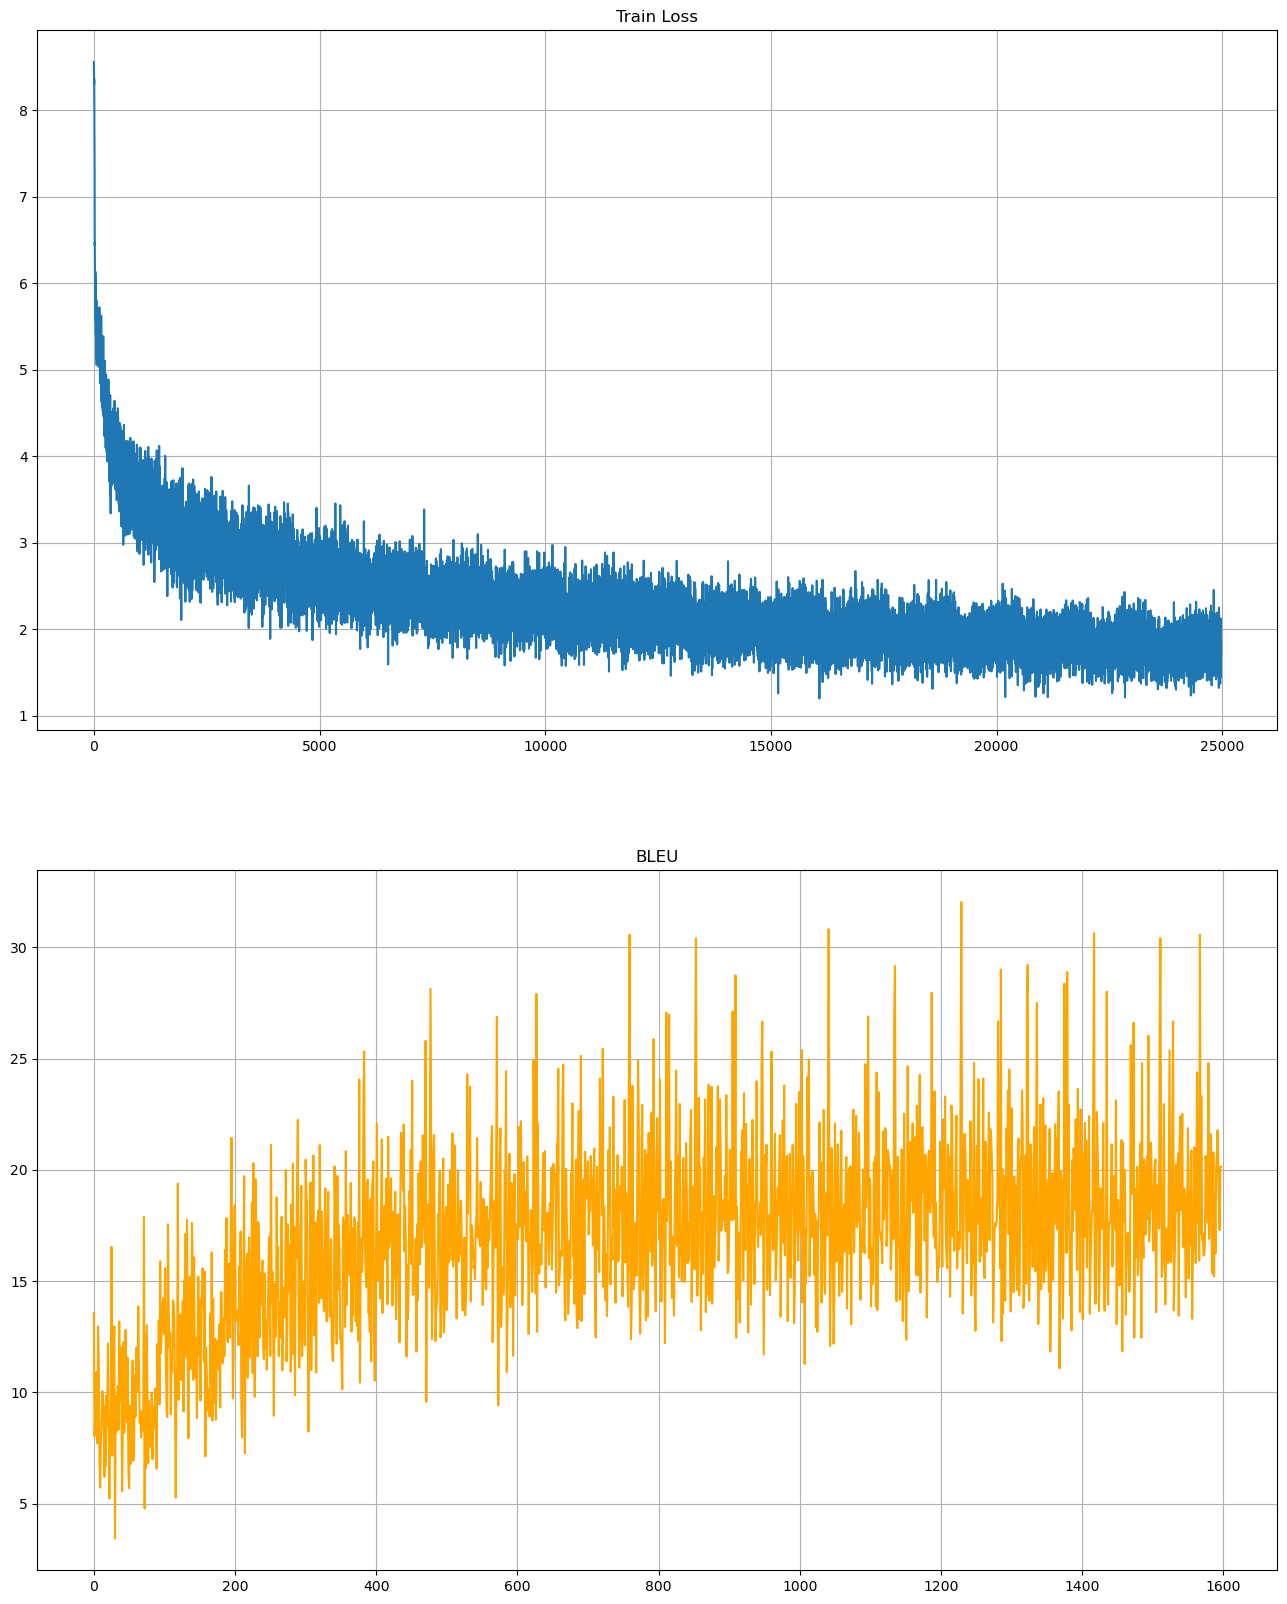

In [23]:
for epoch in range(epoches): 
    model = model.train()
    model.to(device)
    for data in tqdm(train_loader,desc = 'Эпоха '+str(epoch)):
        inp, out = data[0].to(device),data[1].to(device)
        loss = loss_function(model,inp,out)
        loss.backward() 
        opt.step()
        opt.zero_grad()
        metrics['train_loss'].append(loss.cpu().detach().numpy())
    for data in tqdm(dev_loader,desc ='Эпоха валидация'+str(epoch)):
        inp, out = data[0],data[1]
        bleu = compute_bleu(model,inp,out)
        metrics['dev_bleu'].append(bleu)
    clear_output()
    fig = plt.figure(figsize=(16,20))
    ax1,ax2 = fig.subplots(2,1)
    ax1.plot(metrics['train_loss'])
    ax1.grid()
    ax1.set_title('Train Loss')
    ax2.plot(metrics['dev_bleu'],color = 'orange')
    ax2.grid()
    ax2.set_title('BLEU')
    plt.show(block=True)

In [25]:
assert np.mean(metrics['dev_bleu'][-10:], axis=0) > 15, "Ты можешь больше! попробуй еще раз)"

In [26]:
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500])[0]):
    print(inp_line)
    print(trans_line)
    print()

в распоряжении гостей общая кухня и общая гостиная .
guests have access to shared kitchen facilities and shared kitchen facilities .

кроме того , предоставляется прокат велосипедов , услуги трансфера и бесплатная парковка .
rental bicycles and car hire are available at the property .

расстояние до города ки@@ сси@@ м@@ ми составляет 26 км .
the city of jaipur is located 50 km away .

апартаменты в пент@@ хаусе с общим открытым бассейном , садом , кондиционером и террасой для загара расположены в 5 минутах ходьбы от пляжа на курорте ка@@ бо - рой .
located in the centre of playa del este , this apartment features a terrace with a terrace and a terrace . the property is located in the town of riga .

апартаменты mo@@ s@@ co@@ w point - loft red square находятся в москве , в 200 метрах от большого театра .
the property is located in central š@@ ac , 200 metres from the city centre .

в вашем распоряжении собственная ванная комната с душем и полотенцами .
the private bathroom comes with 

## Attention is all you need

### Задание 3

В этом разделе мы хотим, чтобы вы усовершенствовали базовую модель


Сначала напишем слой Attention, а потом внедрим его в уже существующий шаблон

### Attention layer (1 points)

На вход подается скрытые состояния encoder $h^e_0, h^e_1, h^e_2, ..., h^e_T$ и предыдущие состояние декодера $h^d$,

* Считаем логиты:
$$a_t = linear_{out}(tanh(linear_{e}(h^e_t) + linear_{d}(h_d)))$$
* Получаем вероятности из логитов: 
$$ p_t = {{e ^ {a_t}} \over { \sum_\tau e^{a_\tau} }} $$

* Взвешиваем состояния энкодера с полученными вероятностями
$$ attn = \sum_t p_t \cdot h^e_t $$


In [27]:
class AttentionLayer(nn.Module):
    def __init__(self, name, enc_size, dec_size, hid_size,batch_size):
        super().__init__()
        self.name = name
        self.enc_size = enc_size 
        self.dec_size = dec_size 
        self.hid_size = hid_size 
        
        # опишите все слои, которые нужны Attention
        self.tanh = torch.nn.Tanh()
        self.lin_e = torch.nn.Linear(enc_size,hid_size)
        self.lin_d = torch.nn.Linear(dec_size,hid_size)
        self.matr = nn.Parameter(torch.FloatTensor(batch_size,hid_size))

    def forward(self, enc, dec, inp_mask):
        """
        Подсчитываем attention ответ and веса
        :param enc: [batch_size, ninp, enc_size]
        :param dec: decode state[batch_size, dec_size]
        :param inp_mask: маска, 0 там где pading [batch_size, ninp]
        :returns: attn[batch_size, enc_size], probs[batch_size, ninp]
        """

        dec_lay = dec.unsqueeze(1)

 
        # считаем логиты
        logits =self.tanh(self.lin_e(enc)+self.lin_d(dec_lay)).bmm(self.matr.unsqueeze(2)).squeeze(-1)
        
        # Применим маску - если значение маски 0, логиты должны быть -inf или -1e9
        # Лучше использовать torch.where
        logits = torch.where(inp_mask==0,-float('inf'),logits)
        # Примените softmax
        probs = torch.nn.functional.softmax(logits,-1)

        # Подсчитайте выход attention используя enc состояния и вероятностями
        
        attn = probs.unsqueeze(1).bmm(enc).squeeze(1)
        return attn, probs

### Seq2seq model with attention (2 points)

Теперь вы можете использовать уровень внимания для построения сети. Самый простой способ реализовать внимание - использовать его на этапе декодирования:


На каждом шаге используйте предыдущее состояние декодера, и написанный слой Attention




In [42]:
class AttentiveModel(BaseModel):
    def __init__(self, name, inp_voc, out_voc,batch_size,
                 emb_size=64, hid_size=128, attn_size=128):
        """Переводчик с Attention"""
        nn.Module.__init__(self)
        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size
        self.batch_size = batch_size
        
#         <YOUR CODE: initialize layers>
        
        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)
        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True,num_layers = 4)

        self.dec_start = nn.Linear(hid_size, hid_size)
        self.dec0 = nn.GRUCell(hid_size, hid_size)
        self.logits = nn.Linear(hid_size, hid_size)
        
        self.dec1 = nn.GRUCell(hid_size, hid_size)
        self.logits1 = nn.Linear(hid_size, len(out_voc))
        
        self.attn = AttentionLayer('Encod_decod',hid_size, hid_size, hid_size,self.batch_size)
        self.attn1 = AttentionLayer('Encod_decod',hid_size, hid_size, hid_size,self.batch_size)
        self.attn2 = AttentionLayer('Encod_decod',hid_size, hid_size, hid_size,self.batch_size)
        self.lin = nn.Linear(self.hid_size + emb_size,self.hid_size)
        self.lin2 = nn.Linear(self.hid_size*2,self.hid_size)
        self.norm = nn.BatchNorm1d(hid_size)
        self.norm_emb = nn.BatchNorm1d(emb_size)
        self.act =nn.ReLU()
        
        
    def encode(self, inp, **flags):
        
        # делаем encode
        inp_emb = self.emb_inp(inp)
        enc_seq, new_state = self.enc0(inp_emb)
        # enc_seq - vec h_t: [batch, time, hid_size], last_state: [batch, hid_size]
        # последний токен, не последние на самом деле, так как мы делали pading, чтобы тексты были
        # одинакового размер, поэтому подсчитать длину исходного предложения не так уж тривиально
        # ^-- shape: [batch_size, hid_size]
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        dec_start = self.dec_start(last_state)
        inp_mask = self.inp_voc.compute_mask(inp).to(device)
        
        # apply attention layer from initial decoder hidden state
        # применяем attention слой для скрытых состояний
        context, first_attn_probas = self.attn(enc_seq,dec_start, inp_mask)
        # Для декодера нужно вернуть:
        # - начальное состояние для RNN декодера
        # - последовательность скрытых состояний encoder, maskа для них
        # - последним передаем вероятности слоя attention
        
        first_state = [dec_start, enc_seq, inp_mask,context, first_attn_probas]
        return first_state
    

    
    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Принимает предыдущее состояние декодера и токены, возвращает новое состояние и 
        логиты для следующих токенов
        """
        prev_state, enc_hid_states, inp_mask,context, first_attn_probas = prev_state  
        tokens = self.emb_out(prev_tokens)
        tokens = self.lin(torch.cat((tokens, context),dim=-1))
        new_state = self.dec0(tokens, prev_state)
        context, first_attn_probas = self.attn(enc_hid_states,new_state, inp_mask)
        tokens = self.lin(torch.cat((tokens, context),dim=-1))
        new_state = self.dec1(tokens,new_state)
        output_logits = self.logits1(new_state)
        context, first_attn_probas = self.attn1(enc_hid_states,new_state, inp_mask)
        return [new_state, enc_hid_states, inp_mask,context, first_attn_probas], output_logits


### Обучение модели (1 points)

Нужно обучить AttentiveModel и пройти assert по качеству

In [43]:
import wandb

wandb.login(key='3ff07df6eaea051a444363b54d6c49f543cda47c')

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [44]:
from IPython.display import clear_output
from tqdm import tqdm, trange
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

metrics = {'train_loss': [], 'dev_bleu': [] }
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
batch_size = 32

model = AttentiveModel('aten',inp_voc, out_voc,batch_size,emb_size = 64, hid_size = 128,attn_size=128).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

train_set = NlpDataset_tr(inp_voc,out_voc,train_inp, train_out)
dev_set = NlpDataset_dev(dev_inp, dev_out)
train_loader = DataLoader(
    dataset=train_set,
    batch_size= batch_size,
    shuffle=True,
drop_last=True)

dev_loader = DataLoader(
    dataset=dev_set,
    batch_size=batch_size, 
    shuffle=False,
drop_last=True
    )

num_iter = 4096

cuda


In [68]:
epoches = int(num_iter/len(train_loader))
epoches = 5
num_iter = 2048

In [46]:
wandb.init(name='Last_Test_27_Attention-from-scratch_1e-3_2_dec_4_enc_15epoch_0.95exp', project='sem_4_hw_2')

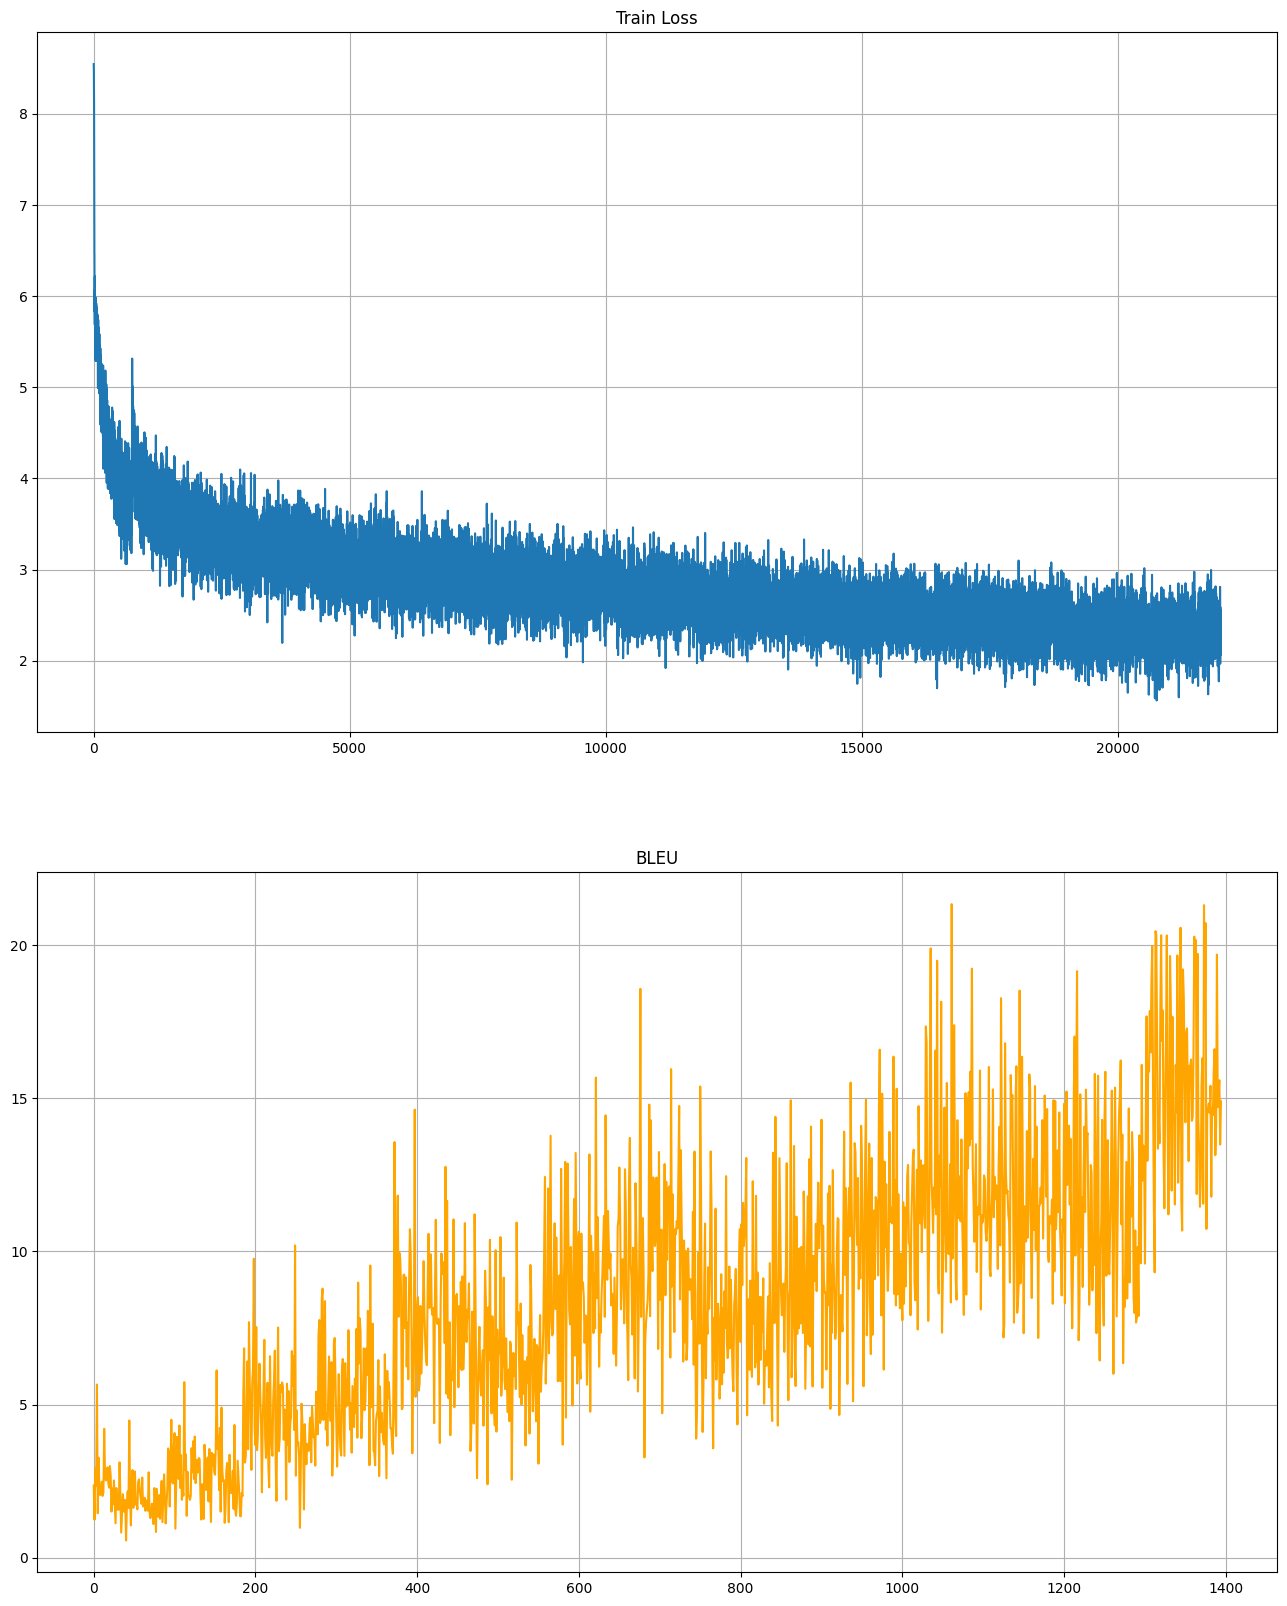

In [47]:
# metrics = {'train_loss': [], 'dev_bleu': [] }
i_loss = 0
i_bleu = 0
# opt.param_groups[0]['lr'] = 1e-4
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.95)
for epoch in range(epoches): 
    model = model.train()
    for data in tqdm(train_loader,desc = 'Эпоха '+str(epoch)):
        inp, out = data[0].to(device),data[1].to(device)
        loss = loss_function(model,inp,out)
        loss.backward() 
        opt.step()
        opt.zero_grad()
        metrics['train_loss'].append(loss.cpu().detach().numpy())
        wandb.log({
        "Epoch": epoch,
        "Train Loss": metrics['train_loss'][-1],
        "Loss_step":i_loss})
        i_loss+=1
    scheduler.step()
    for data in tqdm(dev_loader,desc ='Эпоха валидация'+str(epoch)):
        inp, out = data[0],data[1]
        bleu = compute_bleu(model,inp,out)
        metrics['dev_bleu'].append(bleu)
        wandb.log({'BLEU_metric':metrics['dev_bleu'][-1],
                  "BLEU_step":i_bleu})
        i_bleu +=1
    clear_output()
    fig = plt.figure(figsize=(16,20))
    ax1,ax2 = fig.subplots(2,1)
    ax1.plot(metrics['train_loss'])
    ax1.grid()
    ax1.set_title('Train Loss')
    ax2.plot(metrics['dev_bleu'],color = 'orange')
    ax2.grid()
    ax2.set_title('BLEU')
    plt.show(block=True)

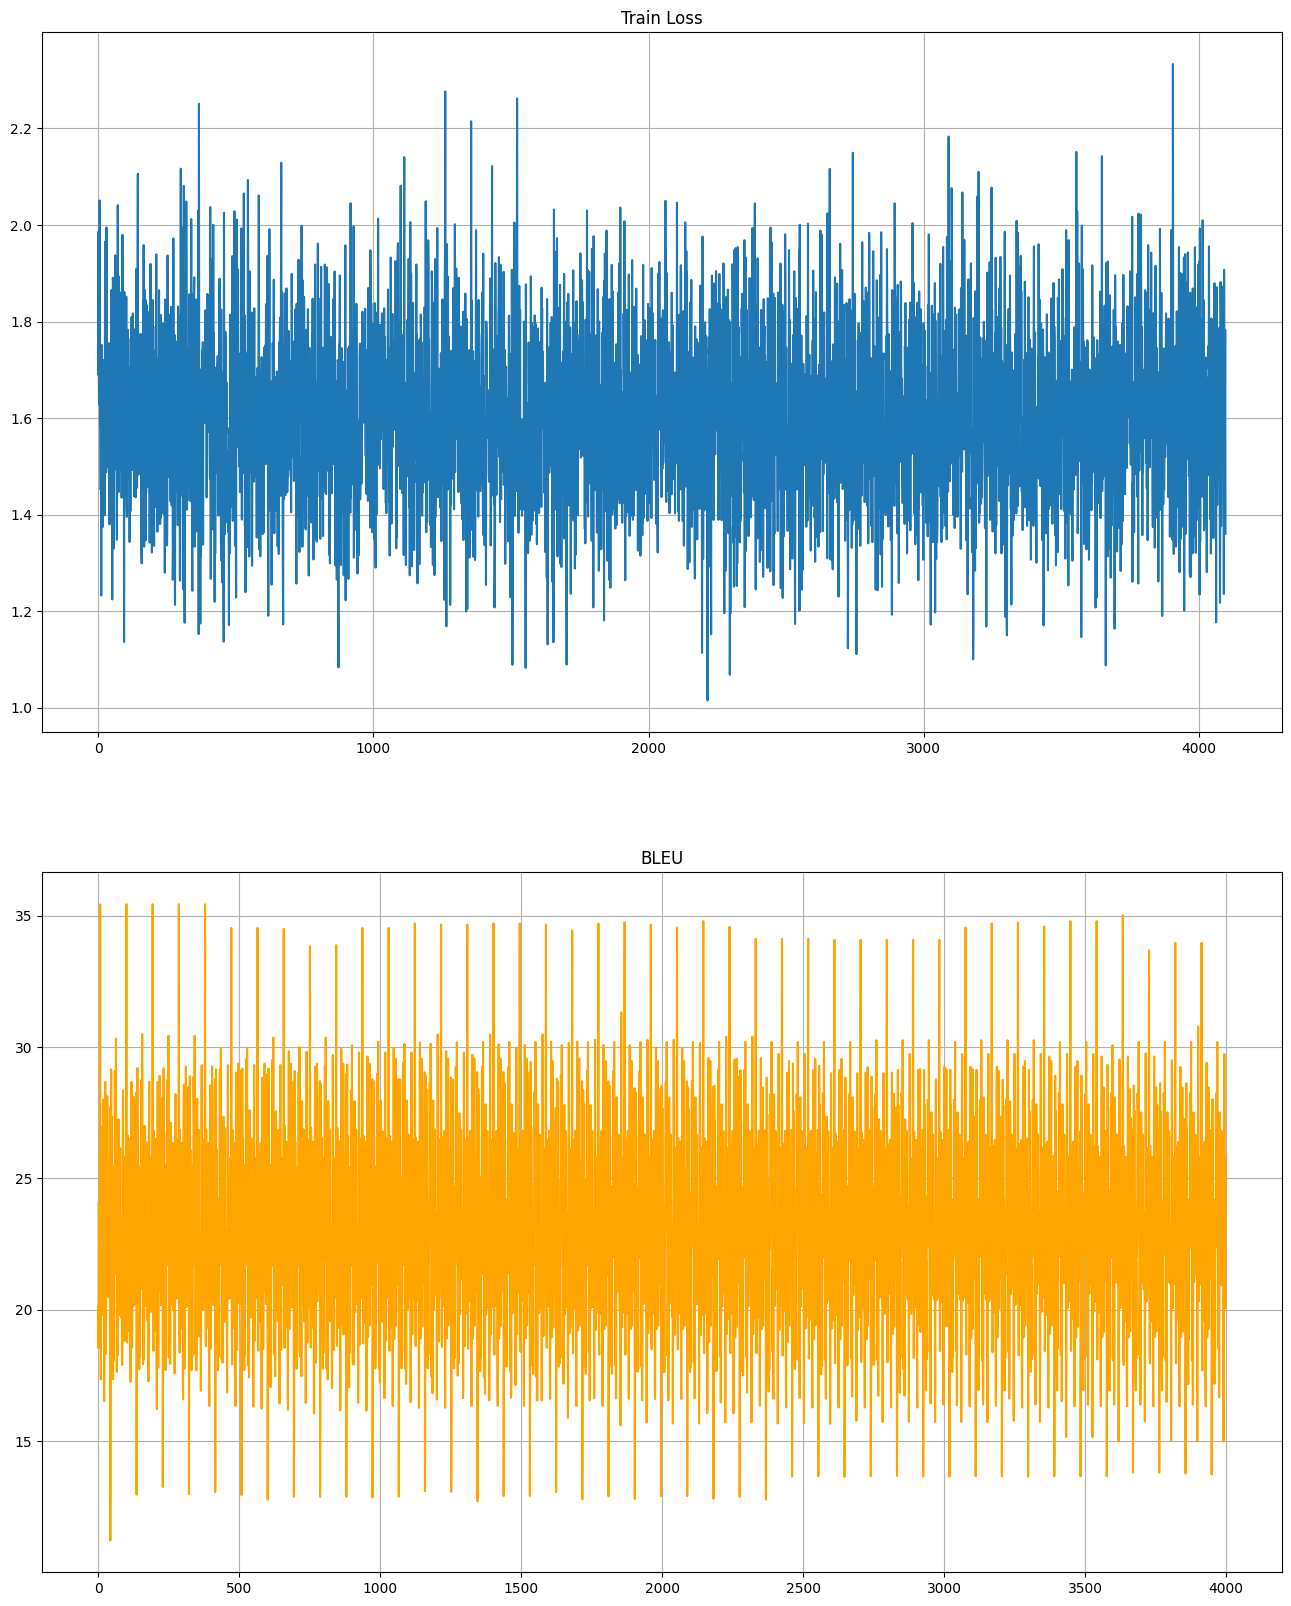

Epoch2::   5%|███▍                                                                  | 100/2048 [00:30<06:46,  4.80it/s]

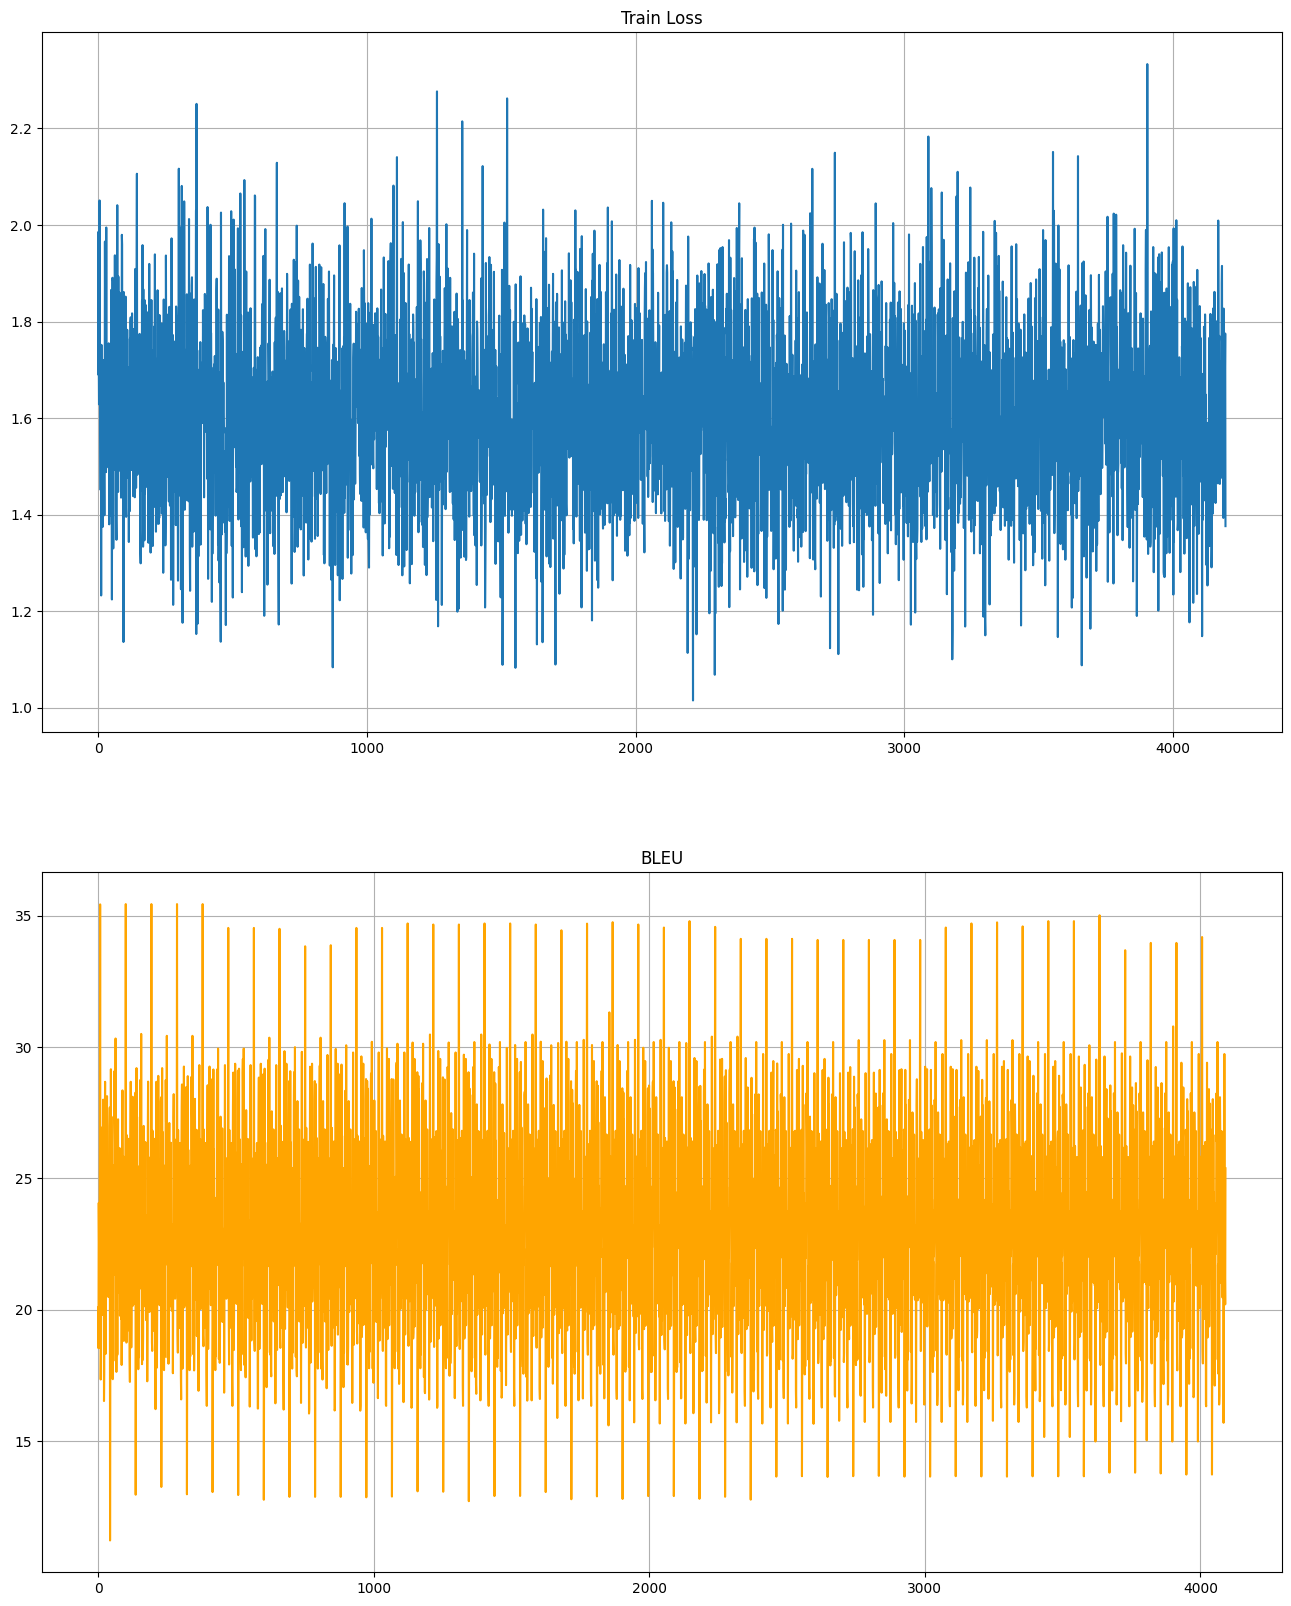

Epoch2::  10%|██████▊                                                               | 200/2048 [00:58<05:12,  5.92it/s]

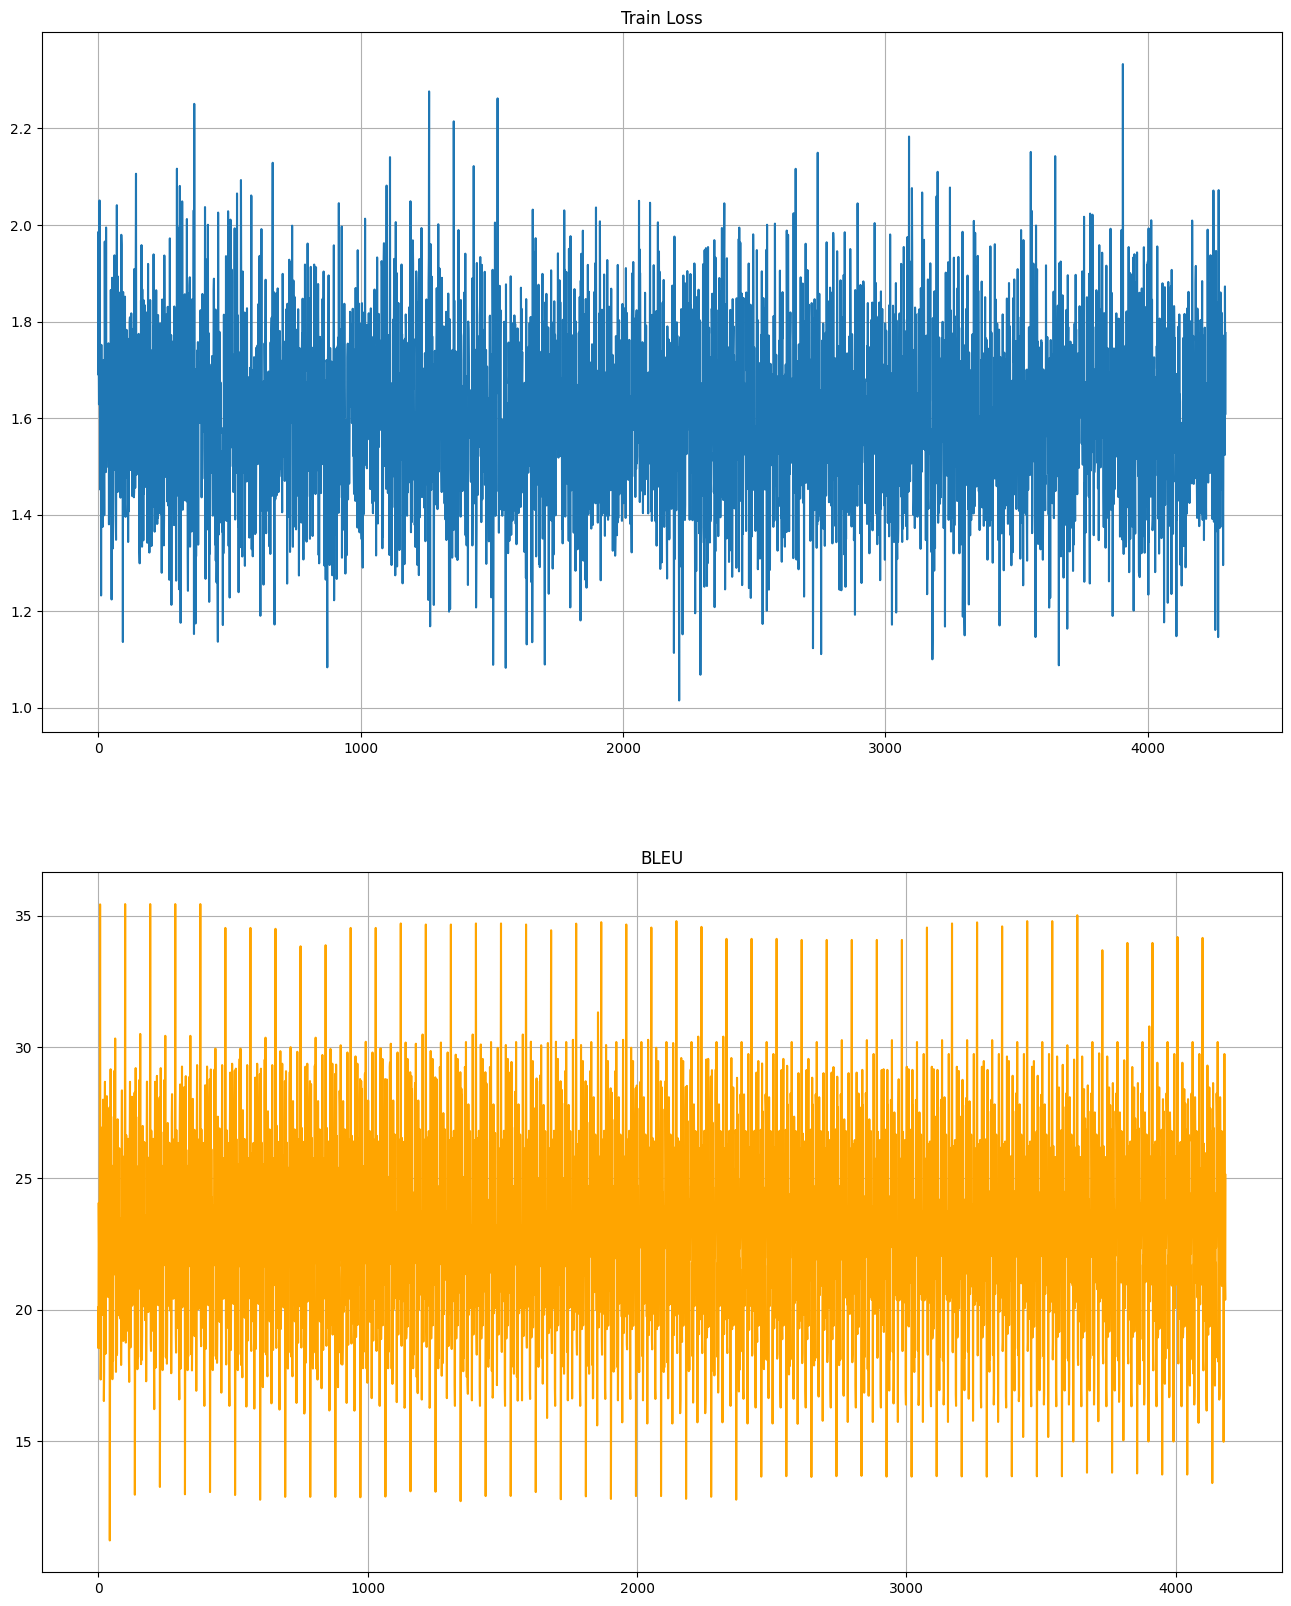

Epoch2::  15%|██████████▎                                                           | 300/2048 [01:27<04:35,  6.35it/s]

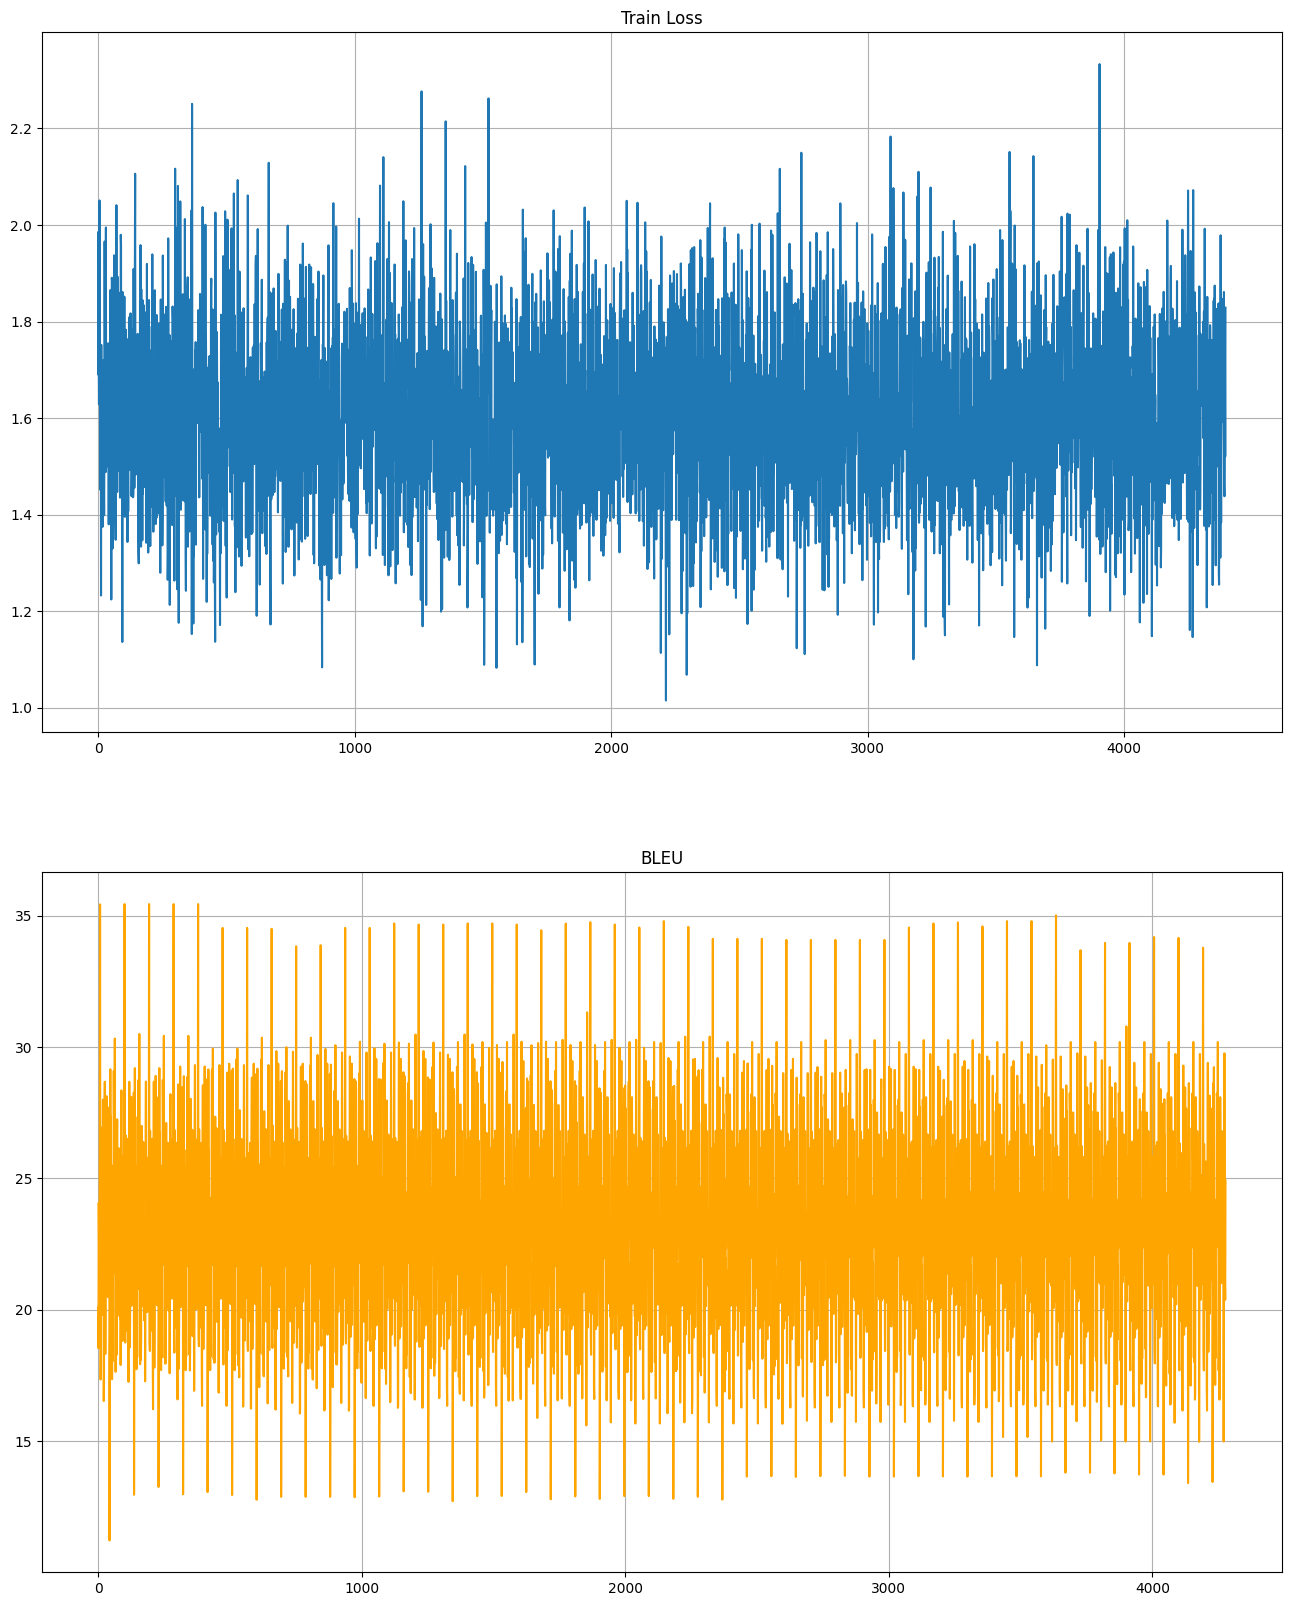

Epoch2::  20%|█████████████▋                                                        | 400/2048 [01:55<05:08,  5.33it/s]

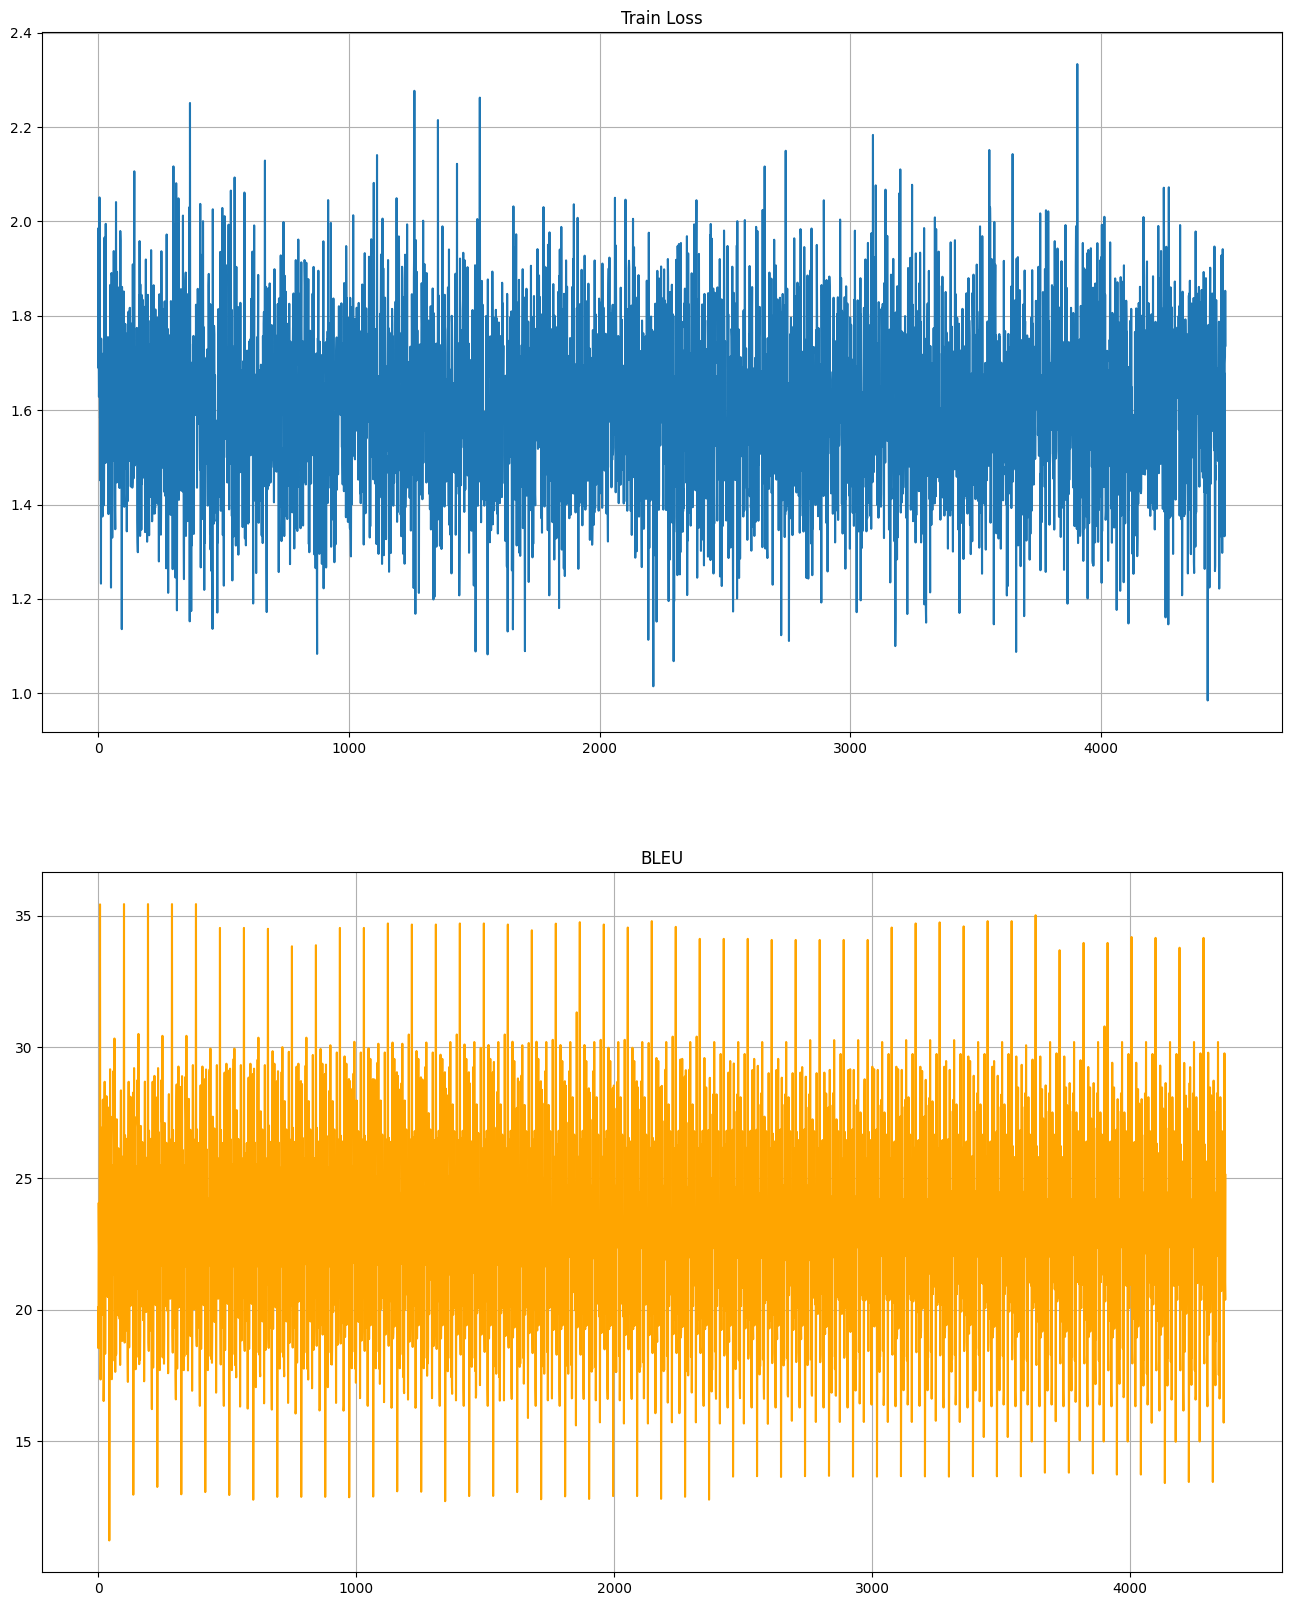

Epoch2::  24%|█████████████████                                                     | 500/2048 [02:25<04:29,  5.74it/s]

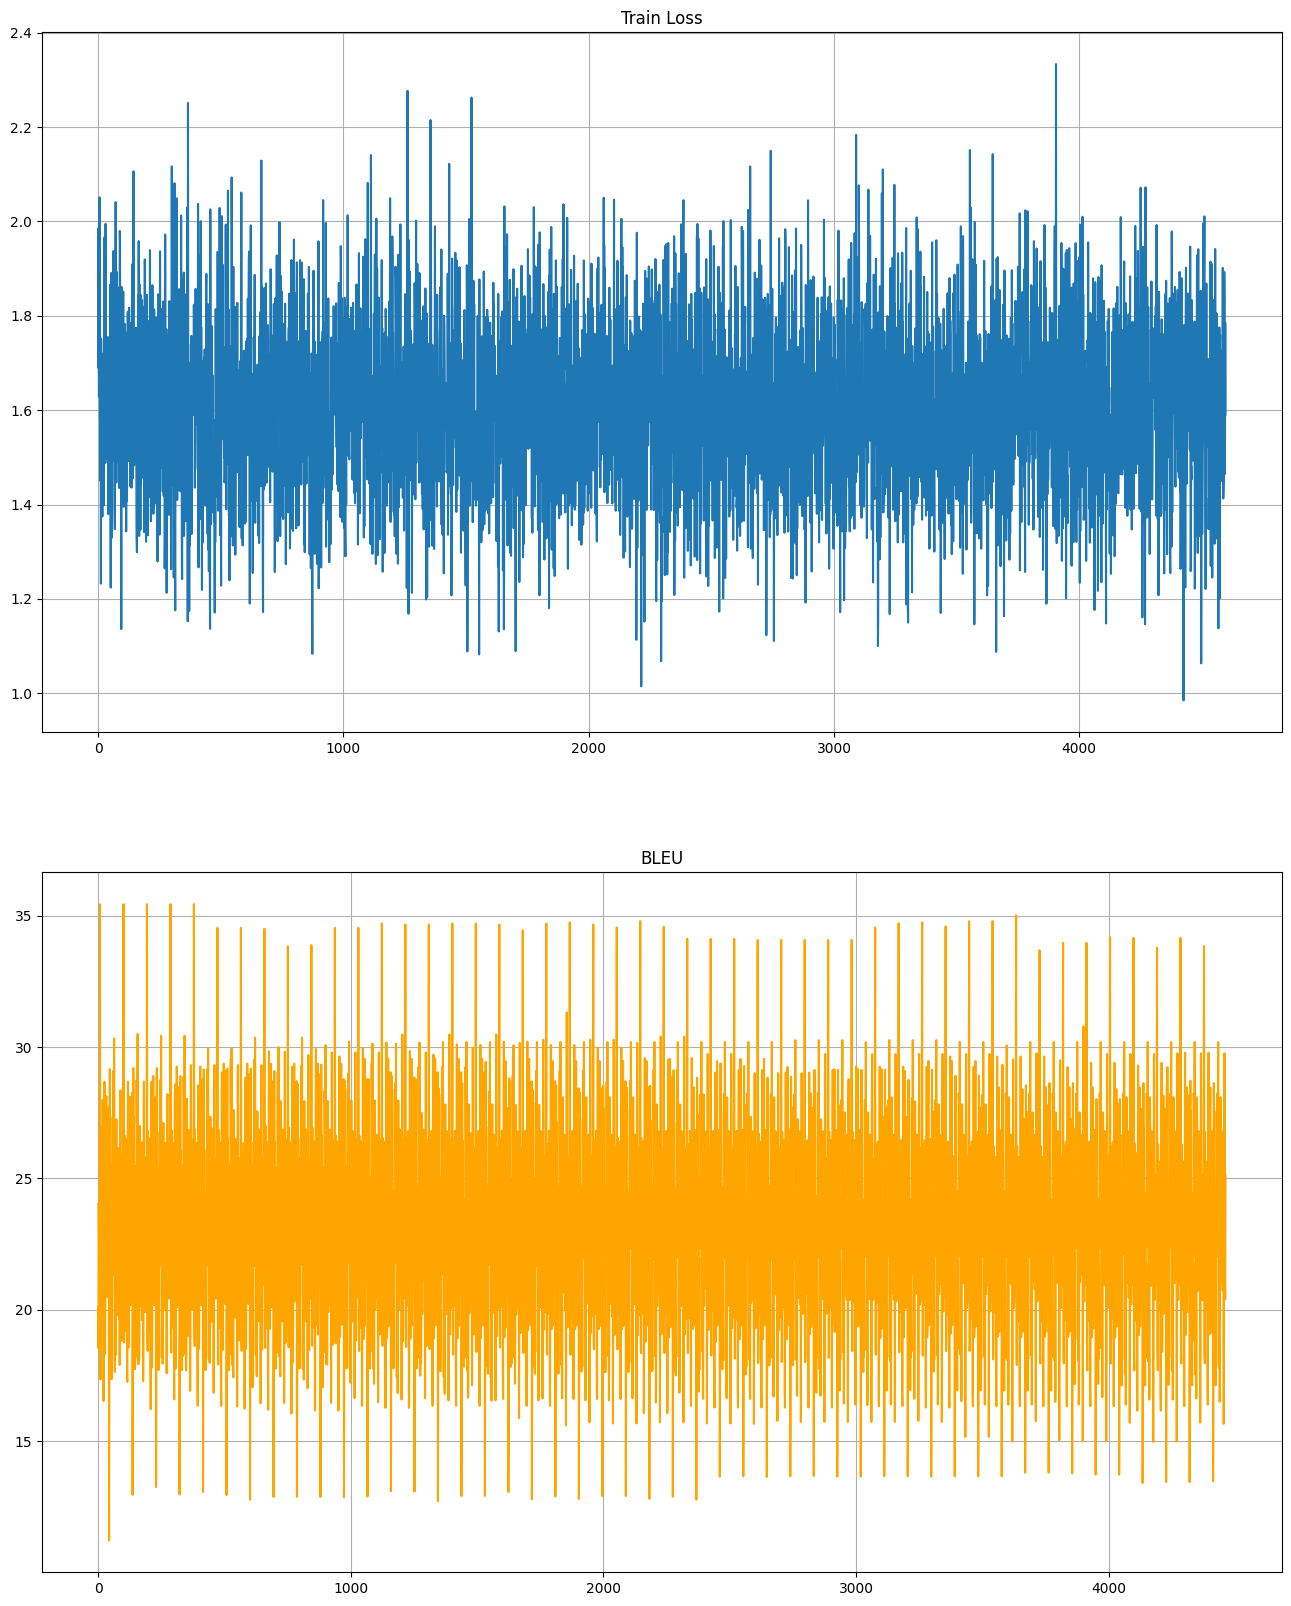

Epoch2::  29%|████████████████████▌                                                 | 600/2048 [02:53<04:18,  5.59it/s]

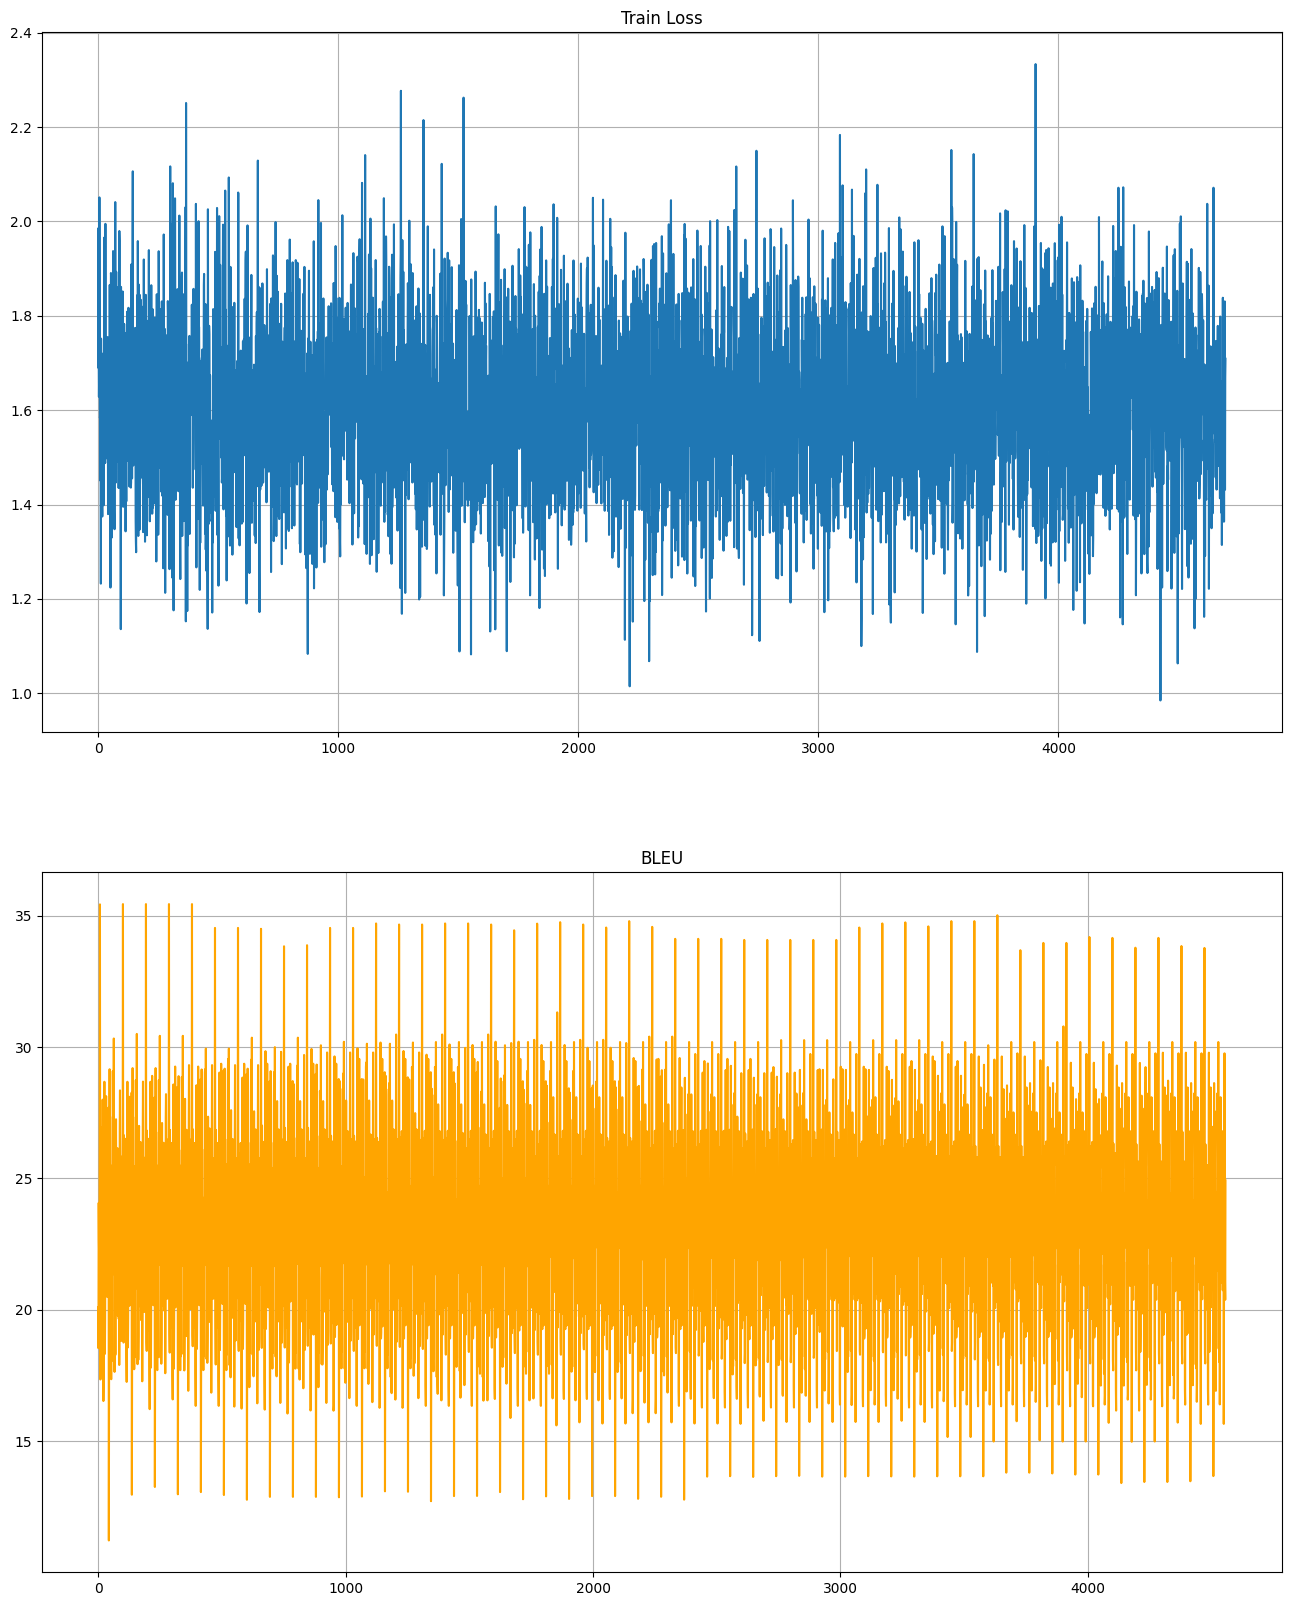

Epoch2::  34%|███████████████████████▉                                              | 700/2048 [03:20<03:25,  6.55it/s]

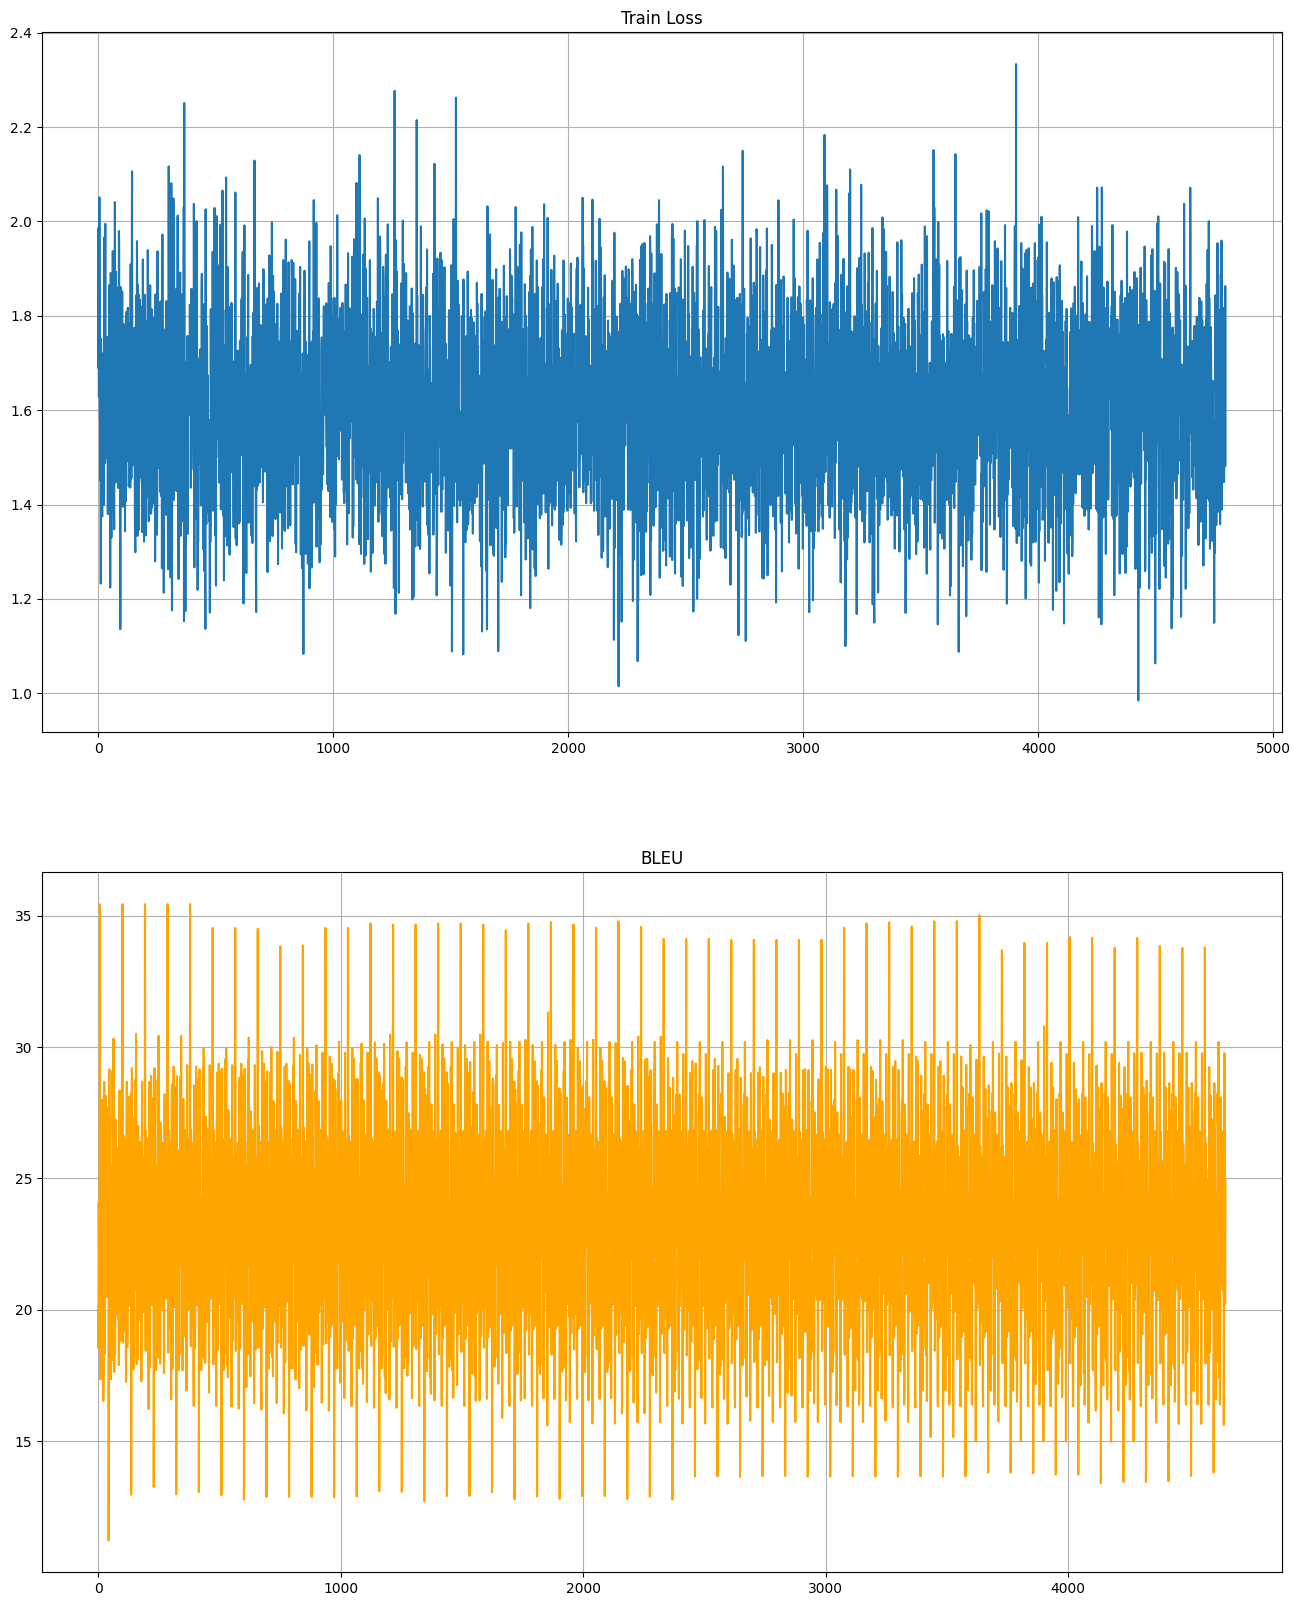

Epoch2::  39%|███████████████████████████▎                                          | 800/2048 [03:50<04:11,  4.96it/s]

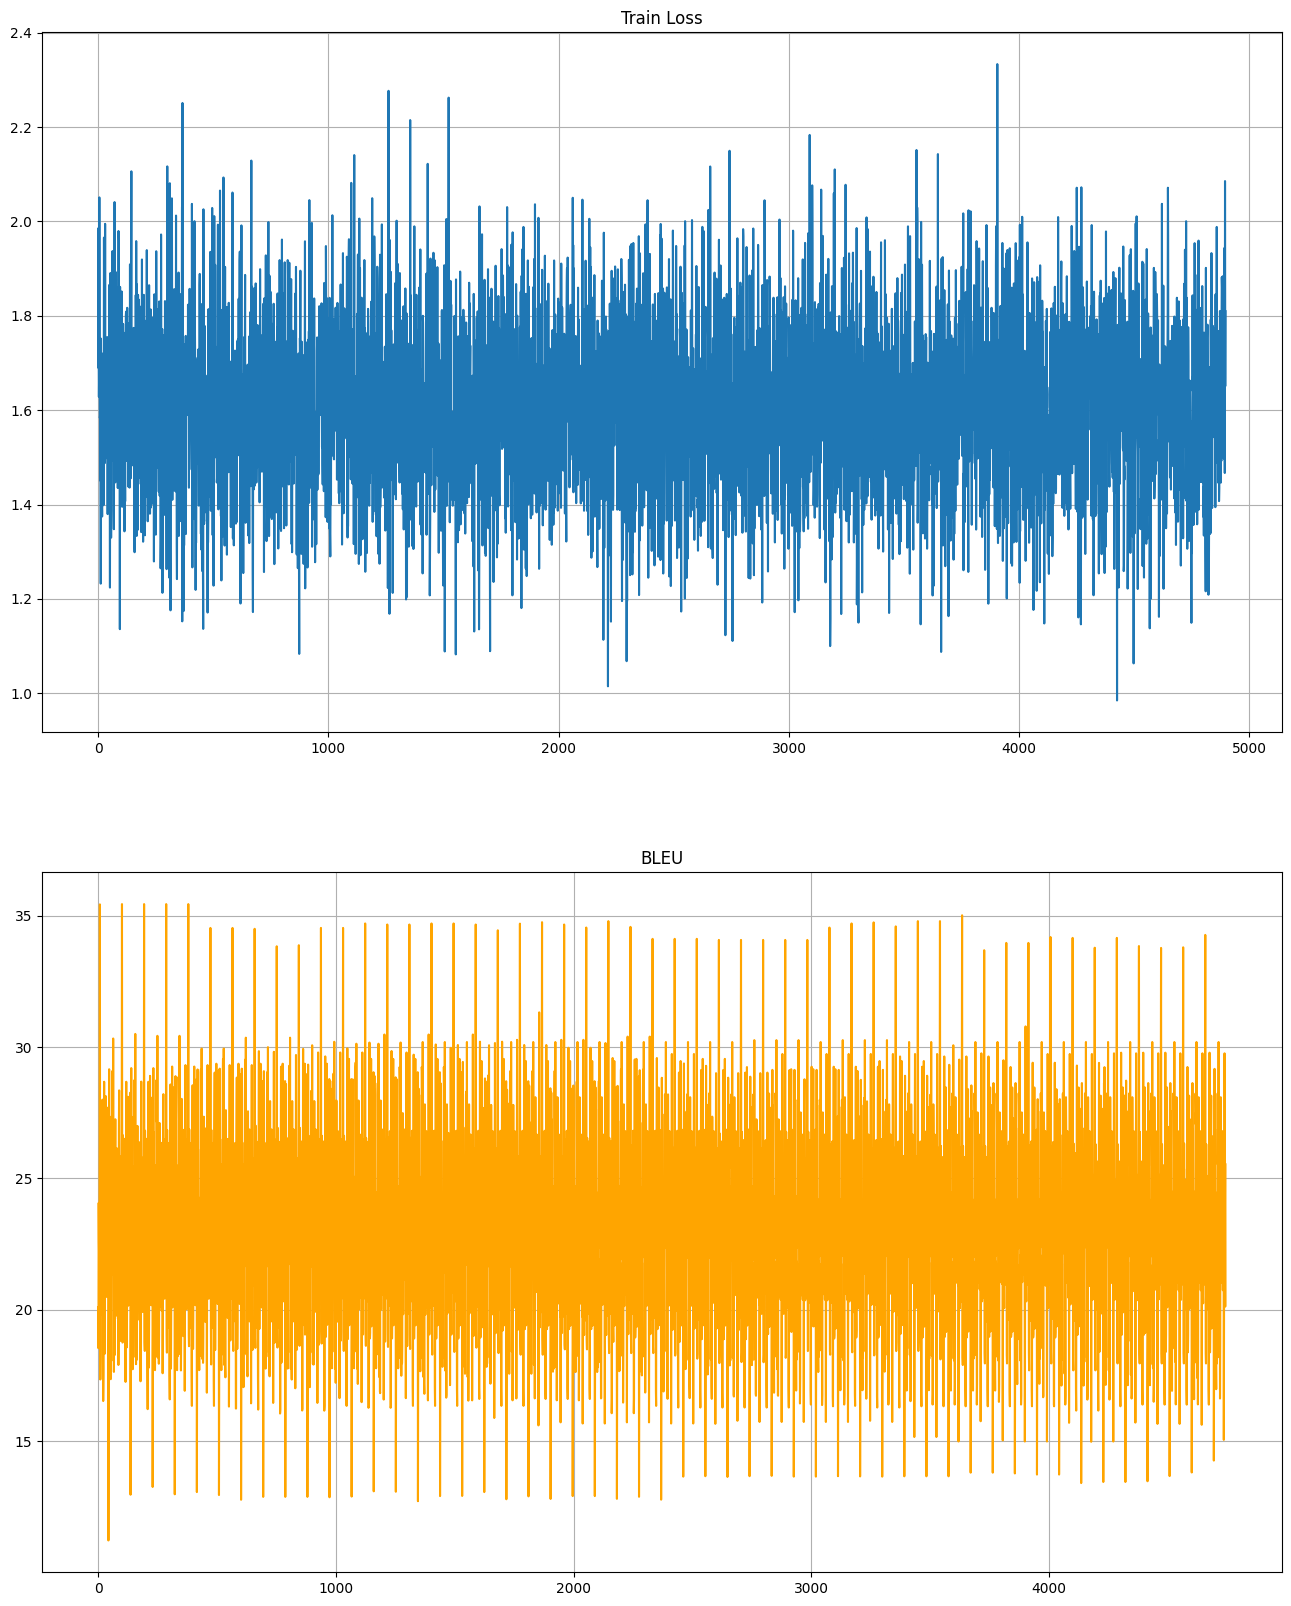

Epoch2::  44%|██████████████████████████████▊                                       | 900/2048 [04:19<04:04,  4.69it/s]

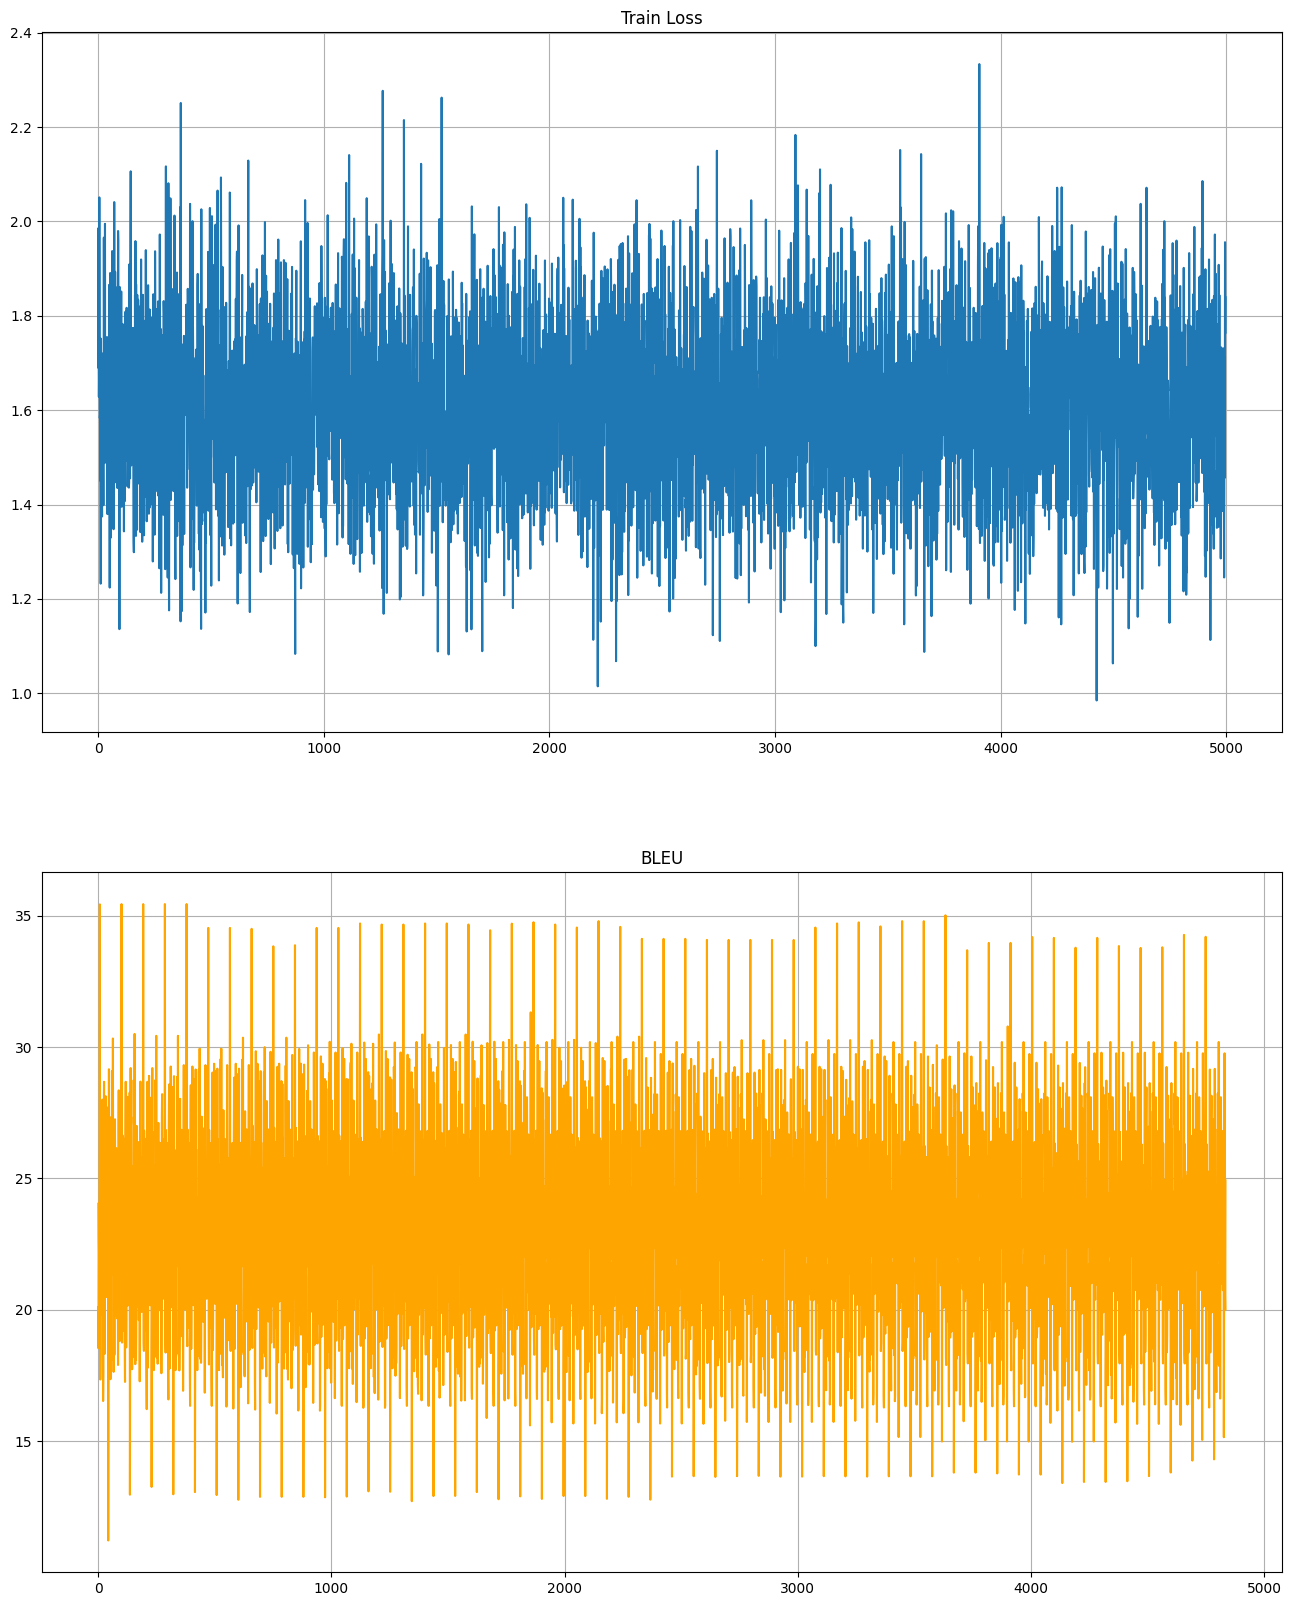

Epoch2::  45%|███████████████████████████████▎                                      | 916/2048 [04:34<03:50,  4.92it/s]

In [69]:
metrics = {'train_loss': [], 'dev_bleu': [] }
opt.param_groups[0]['lr'] = 1e-6
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.95)
for e in range(epoches):
    for i in trange(num_iter,desc="Epoch"+str(e)+":"): 
        model = model.train()
        idx = torch.randint(len(train_inp), size=(batch_size,))
        inp = inp_voc.to_matrix(train_inp[idx]).to(device)
        out = out_voc.to_matrix(train_out[idx]).to(device)
        loss = loss_function(model,inp,out)
        loss.backward() 
        opt.step()
        opt.zero_grad()
        metrics['train_loss'].append(loss.cpu().detach().numpy())
        wandb.log({
        "Epoch": i,
        "Train Loss": metrics['train_loss'][-1],
        "Loss_step":i_loss})
        i_loss+=1
        if i % 1000== 0:
            scheduler.step()
            clear_output()
        if i % 100 == 0:
            for data in dev_loader:
                inp, out = data[0],data[1]
        #         inp = self.inp_voc.to_matrix(inp_lines).to(device)
        #         initial_state = self.encode(inp)
        #         out_ids, states = self.decode_inference(initial_state, **kwargs)
        #         self.out_voc.to_lines(out_ids.cpu().numpy()), states
                bleu = compute_bleu(model,inp,out)
                metrics['dev_bleu'].append(bleu)
                wandb.log({'BLEU_metric':metrics['dev_bleu'][-1],
                          "BLEU_step":i_bleu})
                i_bleu +=1
            fig = plt.figure(figsize=(16,20))
            ax1,ax2 = fig.subplots(2,1)
            ax1.plot(metrics['train_loss'])
            ax1.grid()
            ax1.set_title('Train Loss')
            ax2.plot(metrics['dev_bleu'],color = 'orange')
            ax2.grid()
            ax2.set_title('BLEU')
            plt.show(block=True)
#     

In [71]:
metrics_new = {'dev_bleu': [] }
for data in tqdm(dev_loader,desc ='Эпоха валидация'+str(epoch)):
        inp, out = data[0],data[1]
        bleu = compute_bleu(model,inp,out)
        metrics_new['dev_bleu'].append(bleu)

Эпоха валидация14: 100%|███████████████████████████████████████████████████████████████| 93/93 [00:12<00:00,  7.52it/s]


In [72]:
print(np.mean(metrics['dev_bleu'][-10:], axis=0))    
assert np.mean(metrics['dev_bleu'][-10:], axis=0) > 23, "Ты можешь больше! попробуй еще раз)"

23.185507851523234


In [73]:
wandb.finish()

BLEU_metric,▁▄▄▅▅▄▇▄▇▅▆▅▇▆██▆▇█▅▅▆▇▅▅▅▇▇█▆▆▆▇▇▄▆█▇▄▅
BLEU_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
Epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁██▃▃▃████▃▃▃████▃▃▇▂▂▂▂▆▆▆▆
Loss_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Train Loss,█▆▅▅▅▄▅▄▄▄▄▅▄▄▃▃▃▄▄▃▂▄▃▂▁▃▃▃▂▃▃▂▂▂▃▁▃▂▃▂
BLEU_metric,24.59823
BLEU_step,46964
Epoch,2047
Loss_step,70488
Train Loss,1.63965


## Как решать NLP задачу? Дообучить модель из huggingface

Как мы видели на последнем семинаре в прошлом модуле можно получить отлично качество генерации текста, написав при этом не очень много строк кода, может быть попробовать тут также?)

Это отличная идея!

### Задание 4 (2 points)
 
Нужно взять модель из [huggingface](https://huggingface.co/models?pipeline_tag=translation&sort=downloads), дообучить на наших данных и посмотреть, какое качество

In [28]:
!pip install sentencepiece

In [33]:
import re
import string
import pandas as pd

In [30]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

tokenizer_hug = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-ru-en")
model_hug = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-ru-en").to(device)
# обычно есть How to Get Started With the Model и там показано, как инициализировать модель

/opt/conda/lib/python3.7/site-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [31]:
metrics_hug = {'train_loss': [], 'dev_bleu': [] } 
opt_hug = torch.optim.AdamW(model_hug.parameters(), lr=1e-4)
# можно взять ваш из предыдущих пунктов

In [35]:
inp = pd.DataFrame(np.array(open("/kaggle/input/d/krotdl/dataset/train.bpe.ru").read().split('\n')))
out= pd.DataFrame(np.array(open('/kaggle/input/d/krotdl/dataset/train.bpe.en').read().split('\n')))

In [36]:
inp_tr, inp_test, out_tr, out_test = train_test_split(inp, out, test_size=2024,
                                                          random_state=111)

In [37]:
class HugDataset(Dataset):
    def __init__(self, inp, out):
        self.inp = inp
        self.out = out

    # Координаты прямоугольников советуем вернуть именно в формате (x_center, y_center, width, height)
    def __getitem__(self, idx):
        return self.inp.iloc[idx][0],self.out.iloc[idx][0]

    def __len__(self):
        return len(self.inp)


In [42]:
batch_size = 128
tr_hug_dat = HugDataset(inp_tr,out_tr)
tr_loader = DataLoader(
    dataset=tr_hug_dat,
    batch_size= batch_size,
    shuffle=True)

In [44]:
max_epochs = 2
scheduler_hug = torch.optim.lr_scheduler.ExponentialLR(opt_hug, gamma=0.95)

for epoch in tqdm(range(max_epochs)):
    clear_output()
    model_hug.to(device)
    model_hug.train()
    for i in tqdm(tr_loader,desc = str(epoch)):
        inp, out = data[0],data[1]
        token = tokenizer_hug.prepare_seq2seq_batch(inp,out,return_tensors='pt').to(device)
        trans = model_hug(**token)
        loss = trans.loss
        loss.backward() 
        opt_hug.step()
        opt_hug.zero_grad()
        metrics_hug['train_loss'].append(loss.cpu().detach().numpy())
    scheduler_hug.step()


100%|██████████| 2/2 [01:58<00:00, 59.02s/it]


In [47]:
model_hug.to(device)
loss = 0
n = 10
for i in tqdm(range(n)):
    inp,out= inp_test.iloc[i*n:(i+1)*n,][0], out_test.iloc[i*n:(i+1)*n,][0]
            # preparing the data according to the model input
    token = tokenizer_hug.prepare_seq2seq_batch(list(inp),return_tensors='pt').to(device)
    trans = model_hug.generate(**token)
    trans = tokenizer_hug.batch_decode(trans)
    bleu = corpus_bleu([str(trans).split()], [str(out).split()])*100
    metrics_hug['dev_bleu'].append(bleu)

  0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
 60%|██████    | 6/10 [00:05<00:03,  1.11it/s]/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


In [48]:
np.mean(metrics_hug['dev_bleu'][-10:], axis=0)

45.74489427865964

In [49]:
assert np.mean(metrics_hug['dev_bleu'][-10:], axis=0) > 27, "Ты можешь больше! попробуй еще раз)"